# Sparse regression between model parameters and metagenomic profile

We apply sparse regression using lasso in order to determine if there is a correlation between the model parameters inferred from enzyme dynamics, and the metagenomic profile of a soil sample.

In [1]:
import os, sys
import time
import csv
import tqdm.notebook as tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
import warnings
from sklearn.exceptions import ConvergenceWarning

from mgsa.io import samples_from_soils, get_function, get_data
from mgsa.helpers import plot
from mgsa.modeling import Model

In [2]:
SEED = None
rng = np.random.default_rng(seed=SEED)

In [3]:
NARG_INFO = {
    "KO": "K00370",
    "ORF_GROUPS_FPATH": "../out/groups/assignments_K00370_v1.tsv"
}

NIRB_INFO = {
    "KO": "K00362",
    "ORF_GROUPS_FPATH": "../out/groups/assignments_K00362_v1.tsv"
}

NATIVE_IDXS = [2, 4, 5, 8, 10, 11, 13, 14, 15, 16]
NATIVE_PHS = np.array([5.0, 5.3, 5.41, 5.8, 6.15, 6.3, 6.5, 6.75, 6.9,  7.1])
PERTURBED_PHS = np.linspace(3.8, 8.4, 11)

OUTDIR = "../out/synthetic_model_regression/nar"
IMGDIR = f"{OUTDIR}/images"
os.makedirs(OUTDIR, exist_ok=True)
os.makedirs(IMGDIR, exist_ok=True)

def texify(param_name):
    return {
        "gamma_A": "\\gamma_{{A}}", 
        "gamma_I": "\\gamma_{{I}}", 
        "r_A": "r_{{A}}", 
        "r_I1": "r_{{I1}}", 
        "r_I2": "r_{{I2}}", 
        "K_A": "K_{{A}}", 
        "K_I": "K_{{I}}", 
        "mu": "\\mu", 
    }[param_name]

Load the data.

In [4]:
# Final 3 points will be for fitting the enzyme
t_data = np.linspace(0, 22, 23)

# For the drug data, we only want to fit the Nitrate and Nitrite curves
t_data_drug = np.linspace(0, 19, 20)

soils = [
    'Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 
    'Soil12', 'Soil14', 'Soil15', 'Soil16', 'Soil17'
]

nar_t0 = pd.read_csv(
    '../out/KO_abundances/T0data_K00370.tsv', sep='\t', header=None,
).values
nar_t9_none = pd.read_csv(
    '../out/KO_abundances/T9data_K00370_None.tsv', sep='\t', header=None,
).values
nar_t9_chl = pd.read_csv(
    '../out/KO_abundances/T9data_K00370_CHL.tsv', sep='\t', header=None,
).values

nir_t0 = pd.read_csv(
    '../out/KO_abundances/T0data_K00362.tsv', sep='\t', header=None,
).values
nir_t9_none = pd.read_csv(
    '../out/KO_abundances/T9data_K00362_None.tsv', sep='\t', header=None,
).values
nir_t9_chl = pd.read_csv(
    '../out/KO_abundances/T9data_K00362_CHL.tsv', sep='\t', header=None,
).values

nit_t0 = pd.read_csv(
    '../out/KO_abundances/T0data_K17877.tsv', sep='\t', header=None,
).values
nit_t9_none = pd.read_csv(
    '../out/KO_abundances/T9data_K17877_None.tsv', sep='\t', header=None,
).values
nit_t9_chl = pd.read_csv(
    '../out/KO_abundances/T9data_K17877_CHL.tsv', sep='\t', header=None,
).values

Define models for the CHL+ and CHL- cases.

In [5]:
##############################################################################
### Define the ODE and Model(s)

def RHS(y, params):
    x1, x2, x3, A, I = y
    gamma_A = params['gamma_A']
    gamma_I = params['gamma_I']
    r_A = params['r_A']
    r_I1 = params['r_I1']
    r_I2 = params['r_I2']
    K_A = params['K_A']
    K_I = params['K_I']
    mu = params['mu']

    A = max(A, 1e-10)
    I = max(I, 1e-10)
    alpha = gamma_A*r_A*A/(K_A + A)*x1 + gamma_I*I/(K_I + I)*(r_I1*x2 + r_I2*x3)
    xi_1_temp = gamma_A*r_A*A
    xi_2_temp = gamma_I*r_I1*I
    xi_3_temp = gamma_I*r_I2*I
    xi_1 = xi_1_temp / (xi_1_temp + xi_2_temp + xi_3_temp + 1e-5)
    xi_2 = xi_2_temp / (xi_1_temp + xi_2_temp + xi_3_temp + 1e-5)
    xi_3 = xi_3_temp / (xi_1_temp + xi_2_temp + xi_3_temp + 1e-5)
    dx1 = xi_1*alpha - mu*x1
    dx2 = xi_2*alpha - mu*x2
    dx3 = xi_3*alpha/2 - mu*x3
    dA = -r_A*x1*A/(K_A + A)
    dI = r_A*x1*A/(K_A + A) - (I/(K_I + I))*(r_I1*x2 + r_I2*x3)

    dydt = np.array([dx1, dx2, dx3, dA, dI])
    return dydt


##############################################################################
### Ordered parameters: [gamma_A, gamma_I, r_A, r_I1, r_I2, K_A, K_I, mu]

PARAM_NAMES = ["gamma_A", "gamma_I", "r_A", "r_I1", "r_I2", "K_A", "K_I", "mu"]

# Fixed parameters
K_A = 0.1
K_I = 0.1
mu_chl_pos = 0.0
mu_chl_neg = 0.2

FIXED_PARAMS_CHL_POS = {
    "K_A": K_A, 
    "K_I": K_I, 
    "mu": mu_chl_pos,
    "gamma_A": 0.,
    "gamma_I": 0.,
    "r_I2": 0.,
}
FIXED_PARAMS_CHL_NEG = {
    "K_A": K_A, 
    "K_I": K_I, 
    "mu": mu_chl_neg,
}

NPARAMS_CHL_POS = len(PARAM_NAMES) - len(FIXED_PARAMS_CHL_POS)
NPARAMS_CHL_NEG = len(PARAM_NAMES) - len(FIXED_PARAMS_CHL_NEG)


##############################################################################
### Construct the CHL+ and CHL- models

MODEL_CHL_POS = Model(
    RHS, param_names=PARAM_NAMES, 
    fixed_params=FIXED_PARAMS_CHL_POS,
)

MODEL_CHL_NEG = Model(
    RHS, param_names=PARAM_NAMES, 
    fixed_params=FIXED_PARAMS_CHL_NEG,
)

print("CHL+ Model:\n", MODEL_CHL_POS)
print("CHL- Model:\n", MODEL_CHL_NEG)


CHL+ Model:
 Model [num_params=8, num_inferred=2]
	Fixed params: {'K_A': 0.1, 'K_I': 0.1, 'mu': 0.0, 'gamma_A': 0.0, 'gamma_I': 0.0, 'r_I2': 0.0}
CHL- Model:
 Model [num_params=8, num_inferred=5]
	Fixed params: {'K_A': 0.1, 'K_I': 0.1, 'mu': 0.2}


Load metagenomic profile data for each soil sample.

In [6]:
def load_orf_groups(fpath) -> tuple[dict[int:str], np.ndarray[int]]:
    groups = {}
    idxs = []
    with open(fpath, "r") as f:
        csvreader = csv.reader(f, delimiter=" ")
        for row in csvreader:  # process each row
            orf = row[0]
            gidx = int(row[1])
            if gidx in groups:
                groups[gidx].append(orf)
            else:
                groups[gidx] = [orf]
                idxs.append(gidx)
    return groups, np.sort(idxs)


In [7]:
##############################################################################
##  Collect narG data

# Load ORF groups for narG
nar_groups, nar_group_idxs = load_orf_groups(NARG_INFO["ORF_GROUPS_FPATH"])
total = 0
for gidx in nar_group_idxs:
    group = nar_groups[gidx]
    n = len(group)
    print(f"Group {gidx}: {n} ORFs")
    total += n
print(f"  Total: {total}")

# Aggregate T0 and T9 expression data in the CHL+ and CHL- conditions
gidx2exp_chl_pos_t0 = {gidx: [] for gidx in nar_group_idxs}
gidx2exp_chl_pos_t9 = {gidx: [] for gidx in nar_group_idxs}
gidx2exp_chl_neg_t0 = {gidx: [] for gidx in nar_group_idxs}
gidx2exp_chl_neg_t9 = {gidx: [] for gidx in nar_group_idxs}
for gidx in nar_group_idxs:
    group = nar_groups[gidx]
    for i, orf in enumerate(group):
        data_chl_pos_t0, data_chl_pos_t9 = get_data(
            orf, 
            DATDIR='../out', 
            KO=NARG_INFO["KO"], 
            drug='CHL', 
            map='09',
        )
        data_chl_neg_t0, data_chl_neg_t9 = get_data(
            orf, 
            DATDIR='../out', 
            KO=NARG_INFO["KO"], 
            drug='None', 
            map='09',
        )
        # Subset T0 samples to those of interest
        data_chl_pos_t0 = data_chl_pos_t0[NATIVE_IDXS]
        data_chl_neg_t0 = data_chl_neg_t0[NATIVE_IDXS]

        gidx2exp_chl_pos_t0[gidx].append(data_chl_pos_t0)
        gidx2exp_chl_pos_t9[gidx].append(data_chl_pos_t9)
        gidx2exp_chl_neg_t0[gidx].append(data_chl_neg_t0)
        gidx2exp_chl_neg_t9[gidx].append(data_chl_neg_t9)

    # Sum the expression data in each group
    gidx2exp_chl_pos_t0[gidx] = np.sum(gidx2exp_chl_pos_t0[gidx], axis=0)
    gidx2exp_chl_pos_t9[gidx] = np.sum(gidx2exp_chl_pos_t9[gidx], axis=0)
    gidx2exp_chl_neg_t0[gidx] = np.sum(gidx2exp_chl_neg_t0[gidx], axis=0)
    gidx2exp_chl_neg_t9[gidx] = np.sum(gidx2exp_chl_neg_t9[gidx], axis=0)

# Check lengths are correct
for gidx in nar_group_idxs:
    assert gidx2exp_chl_pos_t0[gidx].shape == (10,), "Wrong shape for t0 pos"
    assert gidx2exp_chl_pos_t9[gidx].shape == (10,11), "Wrong shape for t9 pos"
    assert gidx2exp_chl_neg_t0[gidx].shape == (10,), "Wrong shape for t0 neg"
    assert gidx2exp_chl_neg_t9[gidx].shape == (10,11), "Wrong shape for t9 neg"

# Construct arrays of aggregated soil expression levels. The last axis 
# corresponds to the groups.
nar_exp_chl_pos_t0 = np.zeros([10, len(nar_group_idxs)])
nar_exp_chl_pos_t9 = np.zeros([10, 11, len(nar_group_idxs)])
nar_exp_chl_neg_t0 = np.zeros([10, len(nar_group_idxs)])
nar_exp_chl_neg_t9 = np.zeros([10, 11, len(nar_group_idxs)])
for i, gidx in enumerate(nar_group_idxs):
    nar_exp_chl_pos_t0[...,i] = gidx2exp_chl_pos_t0[gidx]
    nar_exp_chl_pos_t9[...,i] = gidx2exp_chl_pos_t9[gidx]
    nar_exp_chl_neg_t0[...,i] = gidx2exp_chl_neg_t0[gidx]
    nar_exp_chl_neg_t9[...,i] = gidx2exp_chl_neg_t9[gidx]

NUM_VARS_NAR = len(nar_groups)

Group 1: 14 ORFs
Group 2: 4 ORFs
Group 3: 4 ORFs
Group 4: 8 ORFs
Group 5: 6 ORFs
Group 6: 6 ORFs
Group 7: 15 ORFs
  Total: 57


In [8]:
##############################################################################
##  Collect nirB data

# Load ORF groups for nirB
nir_groups, nir_group_idxs = load_orf_groups(NIRB_INFO["ORF_GROUPS_FPATH"])
total = 0
for gidx in nir_group_idxs:
    group = nir_groups[gidx]
    n = len(group)
    print(f"Group {gidx}: {n} ORFs")
    total += n
print(f"  Total: {total}")

# Aggregate T0 and T9 expression data in the CHL+ and CHL- conditions
gidx2exp_chl_pos_t0 = {gidx: [] for gidx in nir_group_idxs}
gidx2exp_chl_pos_t9 = {gidx: [] for gidx in nir_group_idxs}
gidx2exp_chl_neg_t0 = {gidx: [] for gidx in nir_group_idxs}
gidx2exp_chl_neg_t9 = {gidx: [] for gidx in nir_group_idxs}
for gidx in nir_group_idxs:
    group = nir_groups[gidx]
    for i, orf in enumerate(group):
        data_chl_pos_t0, data_chl_pos_t9 = get_data(
            orf, 
            DATDIR='../out', 
            KO=NIRB_INFO["KO"], 
            drug='CHL', 
            map='09',
        )
        data_chl_neg_t0, data_chl_neg_t9 = get_data(
            orf, 
            DATDIR='../out', 
            KO=NIRB_INFO["KO"], 
            drug='None', 
            map='09',
        )
        # Subset T0 samples to those of interest
        data_chl_pos_t0 = data_chl_pos_t0[NATIVE_IDXS]
        data_chl_neg_t0 = data_chl_neg_t0[NATIVE_IDXS]

        gidx2exp_chl_pos_t0[gidx].append(data_chl_pos_t0)
        gidx2exp_chl_pos_t9[gidx].append(data_chl_pos_t9)
        gidx2exp_chl_neg_t0[gidx].append(data_chl_neg_t0)
        gidx2exp_chl_neg_t9[gidx].append(data_chl_neg_t9)

    # Sum the expression data in each group
    gidx2exp_chl_pos_t0[gidx] = np.sum(gidx2exp_chl_pos_t0[gidx], axis=0)
    gidx2exp_chl_pos_t9[gidx] = np.sum(gidx2exp_chl_pos_t9[gidx], axis=0)
    gidx2exp_chl_neg_t0[gidx] = np.sum(gidx2exp_chl_neg_t0[gidx], axis=0)
    gidx2exp_chl_neg_t9[gidx] = np.sum(gidx2exp_chl_neg_t9[gidx], axis=0)

# Check lengths are correct
for gidx in nir_group_idxs:
    assert gidx2exp_chl_pos_t0[gidx].shape == (10,), "Wrong shape for t0 pos"
    assert gidx2exp_chl_pos_t9[gidx].shape == (10,11), "Wrong shape for t9 pos"
    assert gidx2exp_chl_neg_t0[gidx].shape == (10,), "Wrong shape for t0 neg"
    assert gidx2exp_chl_neg_t9[gidx].shape == (10,11), "Wrong shape for t9 neg"

# Construct arrays of aggregated soil expression levels. The last axis 
# corresponds to the groups.
nir_exp_chl_pos_t0 = np.zeros([10, len(nir_group_idxs)])
nir_exp_chl_pos_t9 = np.zeros([10, 11, len(nir_group_idxs)])
nir_exp_chl_neg_t0 = np.zeros([10, len(nir_group_idxs)])
nir_exp_chl_neg_t9 = np.zeros([10, 11, len(nir_group_idxs)])
for i, gidx in enumerate(nir_group_idxs):
    nir_exp_chl_pos_t0[...,i] = gidx2exp_chl_pos_t0[gidx]
    nir_exp_chl_pos_t9[...,i] = gidx2exp_chl_pos_t9[gidx]
    nir_exp_chl_neg_t0[...,i] = gidx2exp_chl_neg_t0[gidx]
    nir_exp_chl_neg_t9[...,i] = gidx2exp_chl_neg_t9[gidx]

NUM_VARS_NIR = len(nir_groups)

Group 1: 6 ORFs
Group 2: 19 ORFs
Group 3: 8 ORFs
Group 4: 6 ORFs
Group 5: 10 ORFs
Group 6: 7 ORFs
Group 7: 6 ORFs
  Total: 62


In [9]:
##############################################################################
##  Normalize narG expression levels

nar_rel_exp_chl_pos_t0 = nar_exp_chl_pos_t0 / np.sum(nar_exp_chl_pos_t0, -1)[...,None]
nar_rel_exp_chl_pos_t9 = nar_exp_chl_pos_t9 / np.sum(nar_exp_chl_pos_t9, -1)[...,None]
nar_rel_exp_chl_neg_t0 = nar_exp_chl_neg_t0 / np.sum(nar_exp_chl_neg_t0, -1)[...,None]
nar_rel_exp_chl_neg_t9 = nar_exp_chl_neg_t9 / np.sum(nar_exp_chl_neg_t9, -1)[...,None]

# Concatenate normalized expression at T0 and T9, with T0 data extending across
# the perturbed pH axis, i.e. the second axis
nar_rel_exp_chl_pos = np.zeros([10, 11, 2 * NUM_VARS_NAR])
nar_rel_exp_chl_neg = np.zeros([10, 11, 2 * NUM_VARS_NAR])

# Include T0 data
nar_rel_exp_chl_pos[:,:,0:NUM_VARS_NAR] = nar_rel_exp_chl_pos_t0[:,None,:]
nar_rel_exp_chl_neg[:,:,0:NUM_VARS_NAR] = nar_rel_exp_chl_neg_t0[:,None,:]

# Include T9 data
nar_rel_exp_chl_pos[:,:,NUM_VARS_NAR:] = nar_rel_exp_chl_pos_t9
nar_rel_exp_chl_neg[:,:,NUM_VARS_NAR:] = nar_rel_exp_chl_neg_t9

np.save(f"{OUTDIR}/nar_relative_expression_t0_chl_pos.npy", nar_rel_exp_chl_pos_t0)
np.save(f"{OUTDIR}/nar_relative_expression_t9_chl_pos.npy", nar_rel_exp_chl_pos_t9)
np.save(f"{OUTDIR}/nar_relative_expression_t0_chl_neg.npy", nar_rel_exp_chl_neg_t0)
np.save(f"{OUTDIR}/nar_relative_expression_t9_chl_neg.npy", nar_rel_exp_chl_neg_t9)


In [10]:
##############################################################################
##  Normalize nirB expression levels

nir_rel_exp_chl_pos_t0 = nir_exp_chl_pos_t0 / np.sum(nir_exp_chl_pos_t0, -1)[...,None]
nir_rel_exp_chl_pos_t9 = nir_exp_chl_pos_t9 / np.sum(nir_exp_chl_pos_t9, -1)[...,None]
nir_rel_exp_chl_neg_t0 = nir_exp_chl_neg_t0 / np.sum(nir_exp_chl_neg_t0, -1)[...,None]
nir_rel_exp_chl_neg_t9 = nir_exp_chl_neg_t9 / np.sum(nir_exp_chl_neg_t9, -1)[...,None]

# Concatenate normalized expression at T0 and T9, with T0 data extending across
# the perturbed pH axis, i.e. the second axis
nir_rel_exp_chl_pos = np.zeros([10, 11, 2 * NUM_VARS_NIR])
nir_rel_exp_chl_neg = np.zeros([10, 11, 2 * NUM_VARS_NIR])

# Include T0 data
nir_rel_exp_chl_pos[:,:,0:NUM_VARS_NIR] = nir_rel_exp_chl_pos_t0[:,None,:]
nir_rel_exp_chl_neg[:,:,0:NUM_VARS_NIR] = nir_rel_exp_chl_neg_t0[:,None,:]

# Include T9 data
nir_rel_exp_chl_pos[:,:,NUM_VARS_NIR:] = nir_rel_exp_chl_pos_t9
nir_rel_exp_chl_neg[:,:,NUM_VARS_NIR:] = nir_rel_exp_chl_neg_t9

np.save(f"{OUTDIR}/nir_relative_expression_t0_chl_pos.npy", nir_rel_exp_chl_pos_t0)
np.save(f"{OUTDIR}/nir_relative_expression_t9_chl_pos.npy", nir_rel_exp_chl_pos_t9)
np.save(f"{OUTDIR}/nir_relative_expression_t0_chl_neg.npy", nir_rel_exp_chl_neg_t0)
np.save(f"{OUTDIR}/nir_relative_expression_t9_chl_neg.npy", nir_rel_exp_chl_neg_t9)


### GENERATE SYNTHETIC DATA


In [11]:
# Maps distribution vector for NAR at T0 to parameter values (CHL+)
T_MATRIX_NAR0_CHL_POS = np.array([
    [.1, 0, .4, .2, 0, 0, .4],  # rule for model parameter r_A
    [0, 0, 0, 0, 0, 0, 0],  # rule for model parameter r_I1
], dtype=float)

# Maps distribution vector for NIR at T0 to parameter values (CHL+)
T_MATRIX_NIR0_CHL_POS = np.array([
    [0, 0, 0, 0, 0, 0, 0],  # rule for model parameter r_A
    [0, 0, .1, .2, .4, .2, 0],  # rule for model parameter r_I1
], dtype=float)

# Maps distribution vector for NAR at T0 to parameter values (CHL-)
T_MATRIX_NAR0_CHL_NEG = np.array([
    [.1, .2, .4, .2, 0, 0, 0],  # rule for model parameter gamma_A
    [0, 0, 0, 0, 0, 0, 0],  # rule for model parameter gamma_I
    [0, 0, .1, .2, .4, .2, 0],  # rule for model parameter r_A
    [0, 0, 0, 0, 0, 0, 0],  # rule for model parameter r_I1
    [0, 0, 0, 0, 0, 0, 0],  # rule for model parameter r_I2
], dtype=float)

# Maps distribution vector for NIR at T0 to parameter values (CHL-)
T_MATRIX_NIR0_CHL_NEG = np.array([
    [0, 0, 0, 0, 0, 0, 0],  # rule for model parameter gamma_A
    [0, 0, .1, .2, .4, .2, 0],  # rule for model parameter gamma_I
    [0, 0, 0, 0, 0, 0, 0],  # rule for model parameter r_A
    [0, 0, .1, .2, .4, .2, 0],  # rule for model parameter r_I1
    [0, 0, .1, .2, .4, .2, 0],  # rule for model parameter r_I2
], dtype=float)


assert T_MATRIX_NAR0_CHL_POS.shape == (NPARAMS_CHL_POS, NUM_VARS_NAR), \
    "Bad shape T_MATRIX_NAR0_CHL_POS"

assert T_MATRIX_NIR0_CHL_POS.shape == (NPARAMS_CHL_POS, NUM_VARS_NIR), \
    "Bad shape T_MATRIX_NIR0_CHL_POS"

assert T_MATRIX_NAR0_CHL_NEG.shape == (NPARAMS_CHL_NEG, NUM_VARS_NAR), \
    "Bad shape T_MATRIX_NAR0_CHL_NEG"

assert T_MATRIX_NIR0_CHL_NEG.shape == (NPARAMS_CHL_NEG, NUM_VARS_NIR), \
    "Bad shape T_MATRIX_NIR0_CHL_NEG"

def transform_chl_pos(p_nar, p_nir):
    return T_MATRIX_NAR0_CHL_POS @ p_nar + T_MATRIX_NIR0_CHL_POS @ p_nir

def transform_chl_neg(p_nar, p_nir):
    return T_MATRIX_NAR0_CHL_NEG @ p_nar + T_MATRIX_NIR0_CHL_NEG @ p_nir


In [12]:
# Generate synthetic model parameters for each soil sample based on variant 
# distributions and the transformation defined above. Use these synthetic
# model parameters to run a simulation and generate timecourse data, with added
# noise.

dt = 0.05
T = 9
N = int(T/dt)
indices = np.linspace(0, int(9/dt-1), 10).astype(int)

NOISE_SCALE = 0.001
noise_scales_chl_pos = NOISE_SCALE * np.ones(5)
noise_scales_chl_neg = NOISE_SCALE * np.ones(5)
assert noise_scales_chl_pos.shape == (5,)
assert noise_scales_chl_neg.shape == (5,)

syn_model_params_chl_pos = np.zeros([10, 11, NPARAMS_CHL_POS])
syn_model_params_chl_neg = np.zeros([10, 11, NPARAMS_CHL_NEG])
syn_functional_data_chl_pos = np.nan * np.ones([10, 11, 5, 10])
syn_functional_data_chl_neg = np.nan * np.ones([10, 11, 5, 10])
for native in tqdm.trange(10, desc="native"):
    for pert in tqdm.trange(11, desc="perturbed", leave=False):
        p_nar_chl_pos = nar_rel_exp_chl_pos[native, pert, 0:NUM_VARS_NAR]
        p_nir_chl_pos = nir_rel_exp_chl_pos[native, pert, 0:NUM_VARS_NIR]
        p_nar_chl_neg = nar_rel_exp_chl_neg[native, pert, 0:NUM_VARS_NAR]
        p_nir_chl_neg = nir_rel_exp_chl_neg[native, pert, 0:NUM_VARS_NIR]
        sp_chl_pos = transform_chl_pos(p_nar_chl_pos, p_nir_chl_pos)
        sp_chl_neg = transform_chl_neg(p_nar_chl_neg, p_nir_chl_neg)
        syn_model_params_chl_pos[native, pert] = sp_chl_pos
        syn_model_params_chl_neg[native, pert] = sp_chl_neg

        # Initial conditions for nar, nir, nit
        scale = nir_t0[native, pert]
        x1_0 = nar_t0[native, pert] / scale
        x2_0 = nir_t0[native, pert] / scale
        x3_0 = nit_t0[native, pert] / scale

        # Collect soil samples for the native/perturbed sample in order to get
        # initial conditions for nitrate and nitrite.
        sample = samples_from_soils(soils[native])[pert]  
        # Load functional data for the CHL+ case
        function = get_function(sample, drug='CHL')
        A0_chl_pos = np.mean(function[0:3,:], axis=0)[0]
        I0_chl_pos = np.mean(function[3:,:], axis=0)[0]
        # Load functional data for the CHL- case
        function = get_function(sample)
        A0_chl_neg = np.mean(function[0:3,:], axis=0)[0]
        I0_chl_neg = np.mean(function[3:,:], axis=0)[0]
        
        # Run simulations (CHL+)
        y0 = np.array([x1_0, x2_0, x3_0, A0_chl_pos, I0_chl_pos])
        params = {
            p: v for p, v 
            in zip(MODEL_CHL_POS.get_inferred_param_names(), sp_chl_pos)
        }
        y_syn = MODEL_CHL_POS.simulate(y0, params, dt, T)
        y_syn += noise_scales_chl_pos[:,None] * rng.standard_normal(y_syn.shape)
        y_syn_chl_pos = y_syn[:,indices]
        syn_functional_data_chl_pos[native, pert, :, :] = y_syn_chl_pos
        nar_t9_chl[native, pert] = y_syn_chl_pos[0,-1]
        nir_t9_chl[native, pert] = y_syn_chl_pos[1,-1]
        nit_t9_chl[native, pert] = y_syn_chl_pos[2,-1]

        # Run simulations (CHL-)
        y0 = np.array([x1_0, x2_0, x3_0, A0_chl_neg, I0_chl_neg])
        params = {
            p: v for p, v 
            in zip(MODEL_CHL_NEG.get_inferred_param_names(), sp_chl_neg)
        }
        y_syn = MODEL_CHL_NEG.simulate(y0, params, dt, T)
        y_syn += noise_scales_chl_neg[:,None] * rng.standard_normal(y_syn.shape)
        y_syn_chl_neg = y_syn[:,indices]
        syn_functional_data_chl_neg[native, pert, :, :] = y_syn_chl_neg
        nar_t9_none[native, pert] = y_syn_chl_neg[0,-1]
        nir_t9_none[native, pert] = y_syn_chl_neg[1,-1]
        nit_t9_none[native, pert] = y_syn_chl_neg[2,-1]


native:   0%|          | 0/10 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

Fit the model.

native:   0%|          | 0/10 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

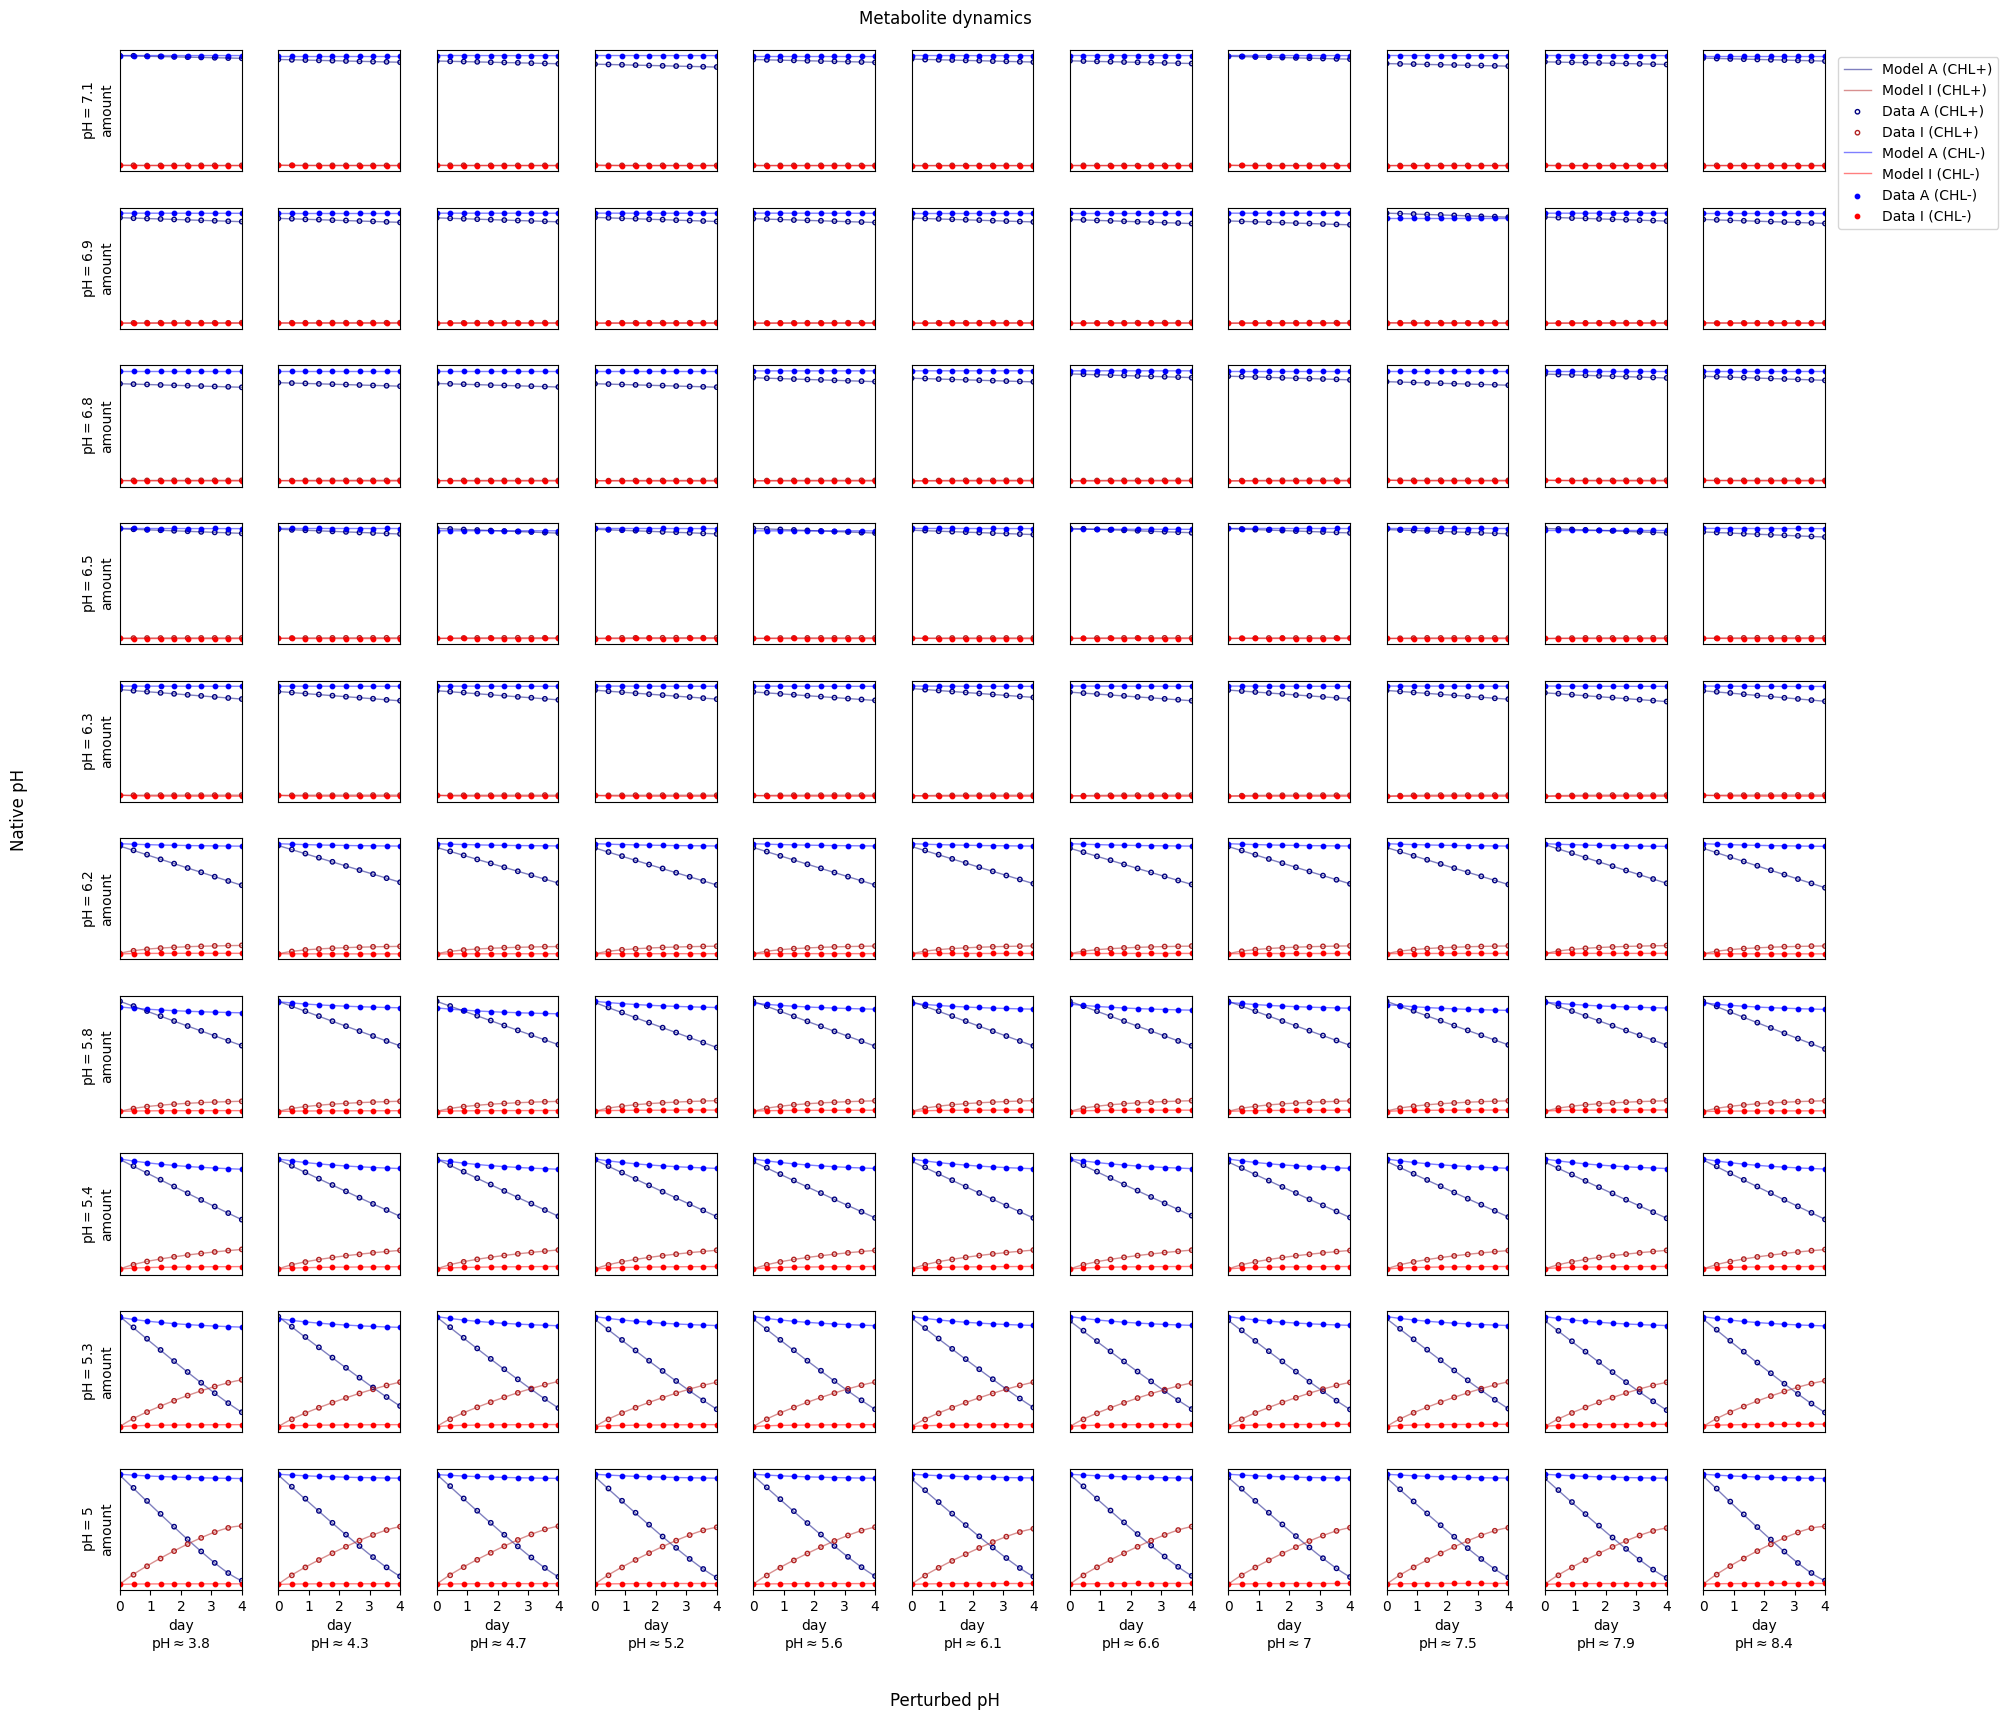

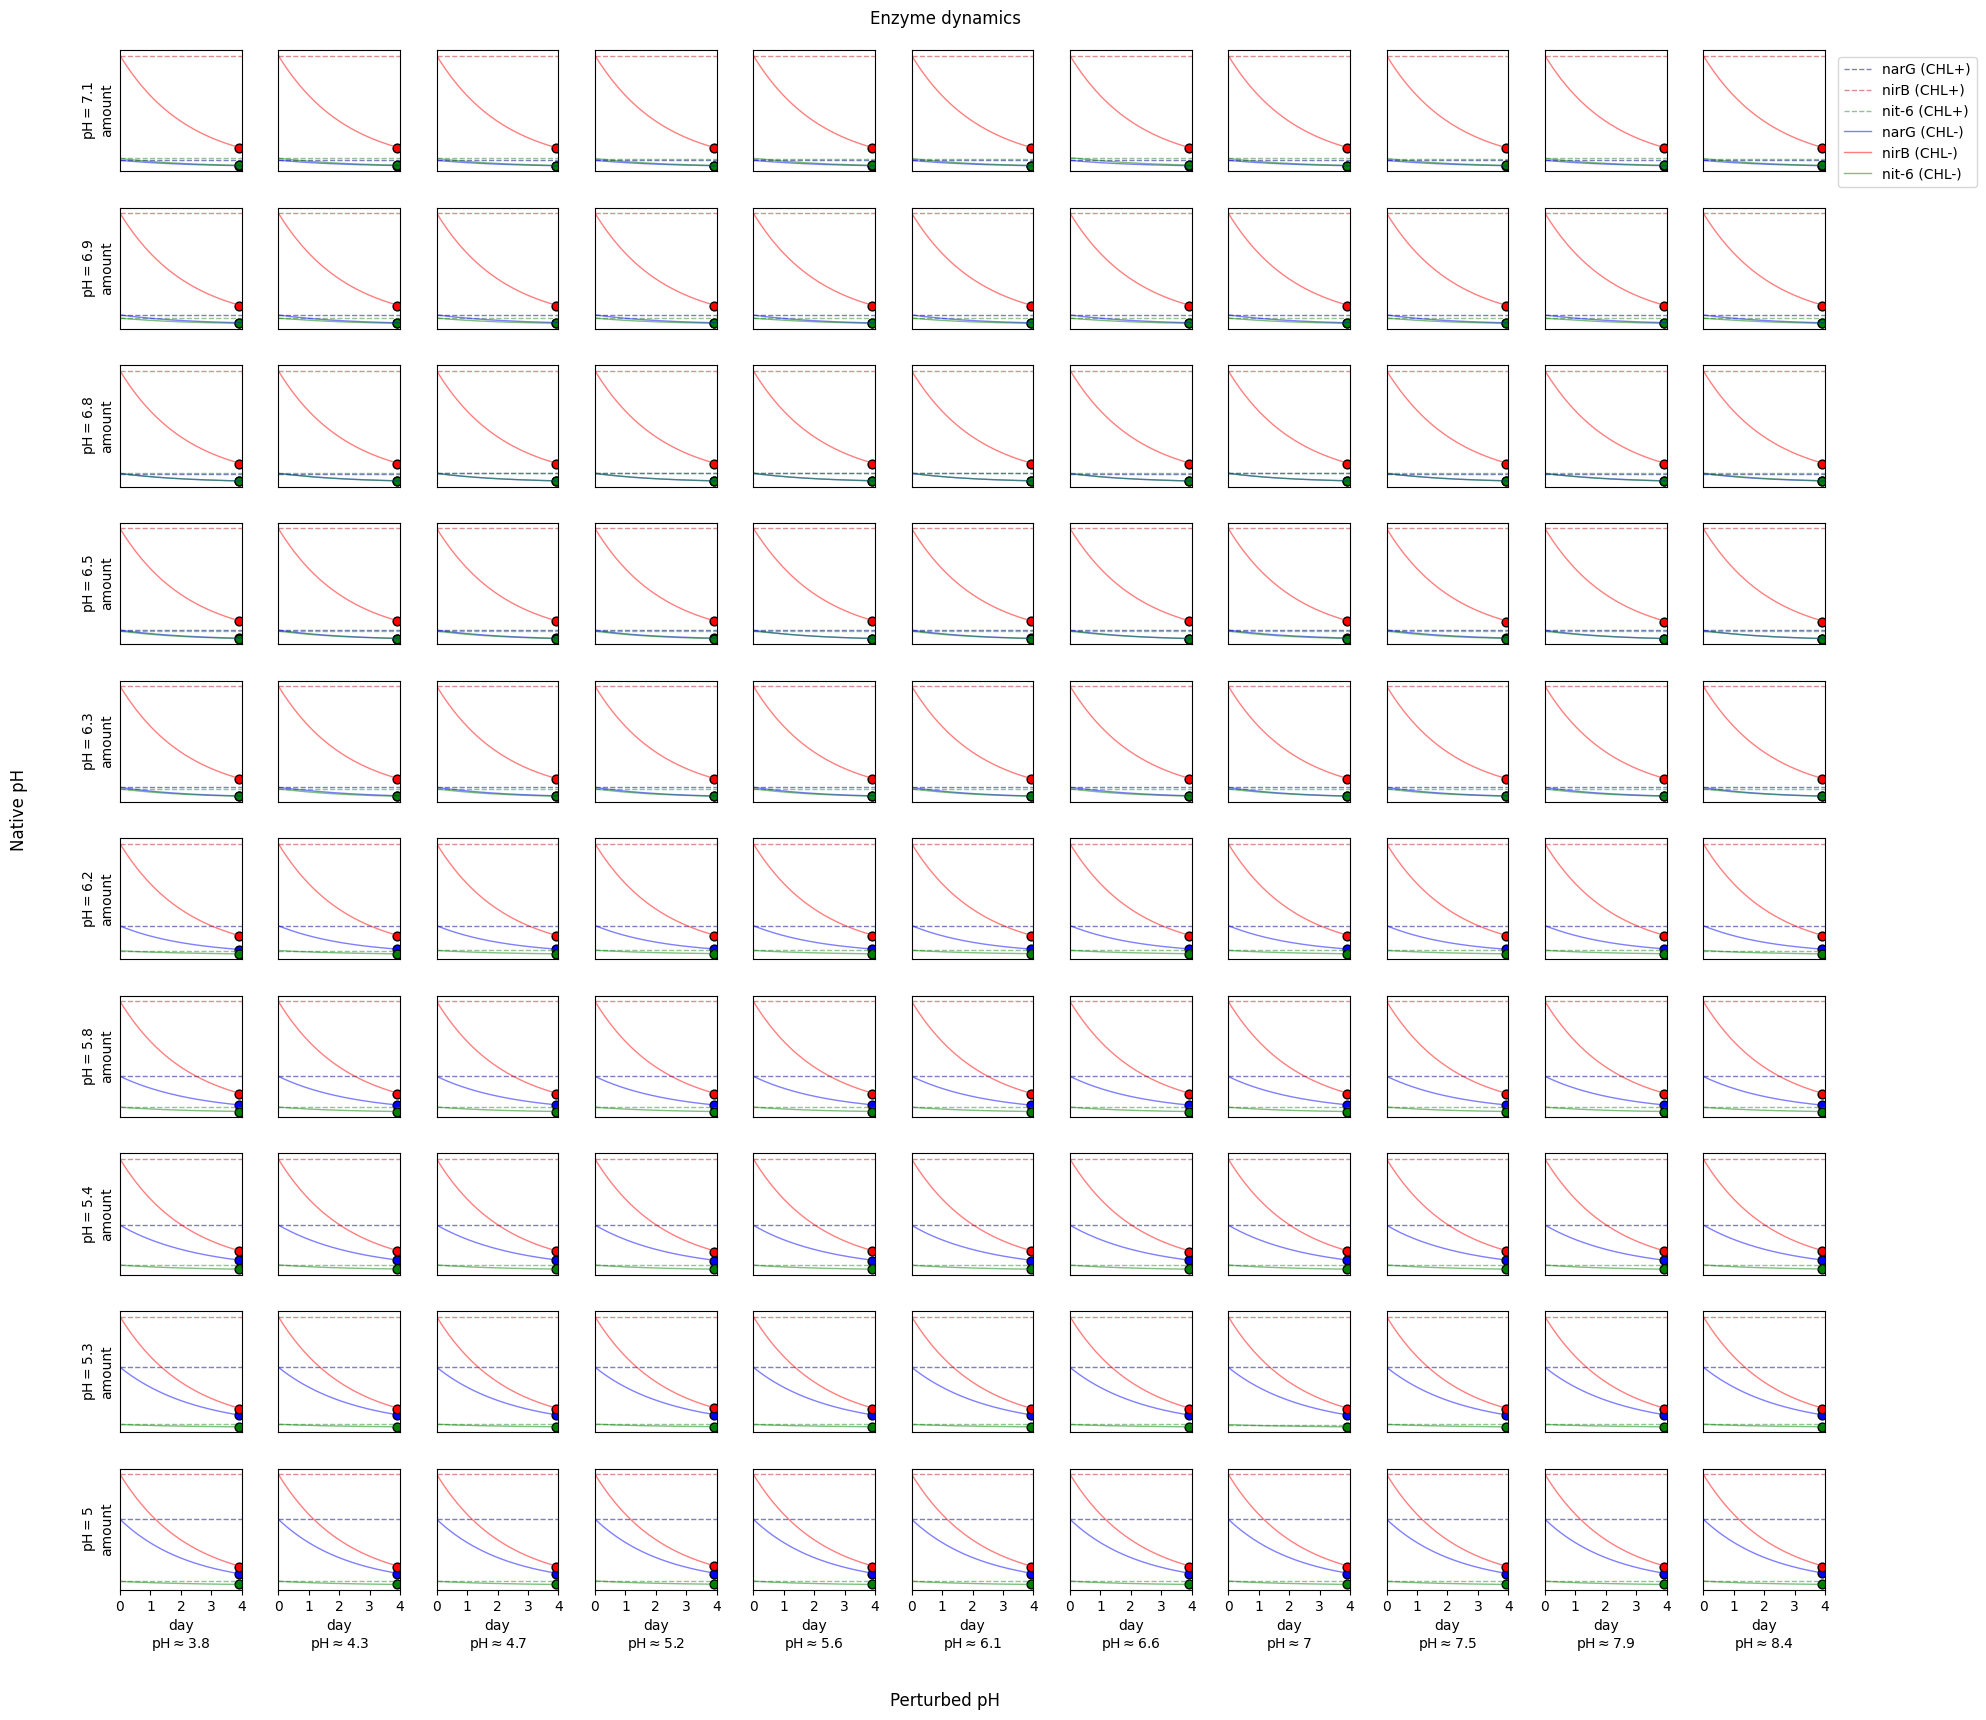

In [13]:
DO_PLOT = True

if DO_PLOT:
    fig_metabs, axs_metabs = plt.subplots(10, 11, figsize=(22, 20))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    fig_enzyme, axs_enzymes = plt.subplots(10, 11, figsize=(22, 20))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)


# Specify a weighting where the biomass points 'matter more' when computing the 
# curve fit. We want to force it to pick parameters so that these enzyme curves 
# do what is expected of them.
sigma = np.ones(23)
sigma[-1] = 1
sigma[-2] = 1
sigma[-3] = 1

# Timestepping
dt = 0.05
T = 9
N = int(T/dt)

indices = np.linspace(0, int(9/dt-1), 10).astype(int)
inferred_params_chl_pos = np.nan * np.ones([10, 11, 2])
inferred_params_chl_neg = np.nan * np.ones([10, 11, 5])
plot_t = np.linspace(0, 9, N)
plot_t_scatter = np.linspace(0, 9, 10)
for native in tqdm.trange(10, desc="native"):
    for pert in tqdm.trange(11, desc="perturbed", leave=False):
        
        # Scaled initial and final enzyme levels
        scale = nir_t0[9 - native, pert]
        x1_0 = nar_t0[9 - native, pert]/scale
        x2_0 = nir_t0[9 - native, pert]/scale
        x3_0 = nit_t0[9 - native, pert]/scale
        x1_f = nar_t9_none[9 - native, pert]
        x2_f = nir_t9_none[9 - native, pert]
        x3_f = nit_t9_none[9 - native, pert]
        
        # Collect soil samples for the native/perturbed sample
        sample = samples_from_soils(soils[9 - native])[pert]
        
        # Load functional data for the CHL+ case
        function = syn_functional_data_chl_pos[9-native, pert, :, :]
        A_data_drug = function[3,:]
        I_data_drug = function[4,:]
        y_data_drug = np.concatenate([A_data_drug, I_data_drug])
        
        # Load functional data for the CHL- case, appending final enzyme levels
        function = syn_functional_data_chl_neg[9-native, pert, :, :]
        A_data = function[3,:]
        I_data = function[4,:]
        y_data = np.concatenate([A_data, I_data, [x1_f, x2_f, x3_f]])
        
        # Fit model (CHL+)
        y0 = np.array([x1_0, x2_0, x3_0, A_data_drug[0], I_data_drug[0]])
        def model_drug(t, r_A, r_I):
            params = {"r_A": r_A, "r_I1": r_I}
            _, _, _, A, I = MODEL_CHL_POS.simulate(y0, params, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            return np.concatenate([A_out, I_out])
        
        initial_guess = [0.1, 0.1]
        bounds = (
            [0.001, 0.001], 
            [10, 10],
        )
        popt, pcov = curve_fit(
            model_drug, t_data_drug, y_data_drug, 
            p0=initial_guess, 
            bounds=bounds,
            maxfev=100000,
        )
        inferred_params_chl_pos[9-native, pert, :] = popt

        if DO_PLOT:
            # Plot the inferred model (CHL+)
            params = {"r_A": popt[0], "r_I1": popt[1]}
            x1, x2, x3, A, I = MODEL_CHL_POS.simulate(y0, params, dt, T)

            axtitle = ", ".join(
                [f"${texify(p)}={popt[i]:.2g}$" 
                 for i, p in enumerate(MODEL_CHL_POS.get_inferred_param_names())]
            )
            
            # Plot metabolites (CHL+)
            ax = axs_metabs[native, pert]
            ax.plot(
                plot_t, A, 
                color='navy', alpha=0.5, linewidth=1, 
                label="Model A (CHL+)"
            )
            ax.plot(
                plot_t, I, 
                color='firebrick', alpha=0.5, linewidth=1,
                label="Model I (CHL+)"
            )
            ax.scatter(
                plot_t_scatter, A_data_drug, 
                color='navy', s=10, facecolors='none',
                label="Data A (CHL+)"
            )
            ax.scatter(
                plot_t_scatter, I_data_drug, 
                color='firebrick', s=10, facecolors='none',
                label="Data I (CHL+)"
            )
            
            # Plot enzymes (CHL+)
            ax = axs_enzymes[native, pert]
            ax.plot(
                plot_t, x1, 
                color='navy', alpha=0.5, linewidth=1, linestyle='--',
                label="narG (CHL+)"
            )
            ax.plot(
                plot_t, x2, 
                color='firebrick', alpha=0.5, linewidth=1, linestyle='--',
                label="nirB (CHL+)"
            )
            ax.plot(
                plot_t, x3, 
                color='forestgreen', alpha=0.5, linewidth=1, linestyle='--',
                label="nit-6 (CHL+)"
            )
        
        # Fit model (CHL-)
        y0 = np.array([x1_0, x2_0, x3_0, A_data[0], I_data[0]])
        def model(t, gamma_A, gamma_I, r_A, r_I1, r_I2):
            params = {
                "gamma_A": gamma_A, "gamma_I": gamma_I, 
                "r_A": r_A, "r_I1": r_I1, "r_I2": r_I2
            }
            x1, x2, x3, A, I = MODEL_CHL_NEG.simulate(y0, params, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            x1_out = x1[indices]
            x2_out = x2[indices]
            x3_out = x3[indices]
            y_out = np.concatenate([A_out, I_out, [x1_out[-1], x2_out[-1], x3_out[-1]]])
            return y_out
        
        initial_guess = [2, 1, 0.01, 0.1, 0.1]
        bounds = (
            [0.001, 0.001, 0.0001, 0.0001, 0.0001], 
            [10, 10, 10, 10, 10],
        )
        
        popt, pcov = curve_fit(
            model, t_data, y_data, 
            p0=initial_guess, 
            bounds=bounds,
            maxfev=10000,
            sigma=sigma,
        )
        
        inferred_params_chl_neg[9-native, pert, :] = popt
        
        if DO_PLOT:
            # Plot the inferred model (CHL-)
            params = {
                "gamma_A": popt[0], "gamma_I": popt[1], 
                "r_A": popt[2], "r_I1": popt[3], "r_I2": popt[4]
            }
            x1, x2, x3, A, I = MODEL_CHL_NEG.simulate(y0, params, dt, T)
        
            # Plot metabolites (CHL-)
            ax = axs_metabs[native, pert]
            ax.plot(
                plot_t, A, color='Blue', alpha=0.5, linewidth=1,
                label="Model A (CHL-)"
            )
            ax.plot(
                plot_t, I, color='Red', alpha=0.5, linewidth=1,
                label="Model I (CHL-)"
            )
            ax.scatter(
                plot_t_scatter, A_data, color='Blue', s=10, 
                label="Data A (CHL-)"
            )
            ax.scatter(
                plot_t_scatter, I_data, color='Red', s=10, 
                label="Data I (CHL-)"
            )
            
            # Plot enzymes (CHL-)
            ax = axs_enzymes[native, pert]
            ax.plot(
                plot_t, x1, color='Blue', alpha=0.5, linewidth=1,
                label="narG (CHL-)"
            )
            ax.plot(
                plot_t, x2, color='Red', alpha=0.5, linewidth=1,
                label="nirB (CHL-)"
            )
            ax.plot(
                plot_t, x3, color='Green', alpha = 0.5, linewidth=1,
                label="nit-6 (CHL-)"
            )
            ax.scatter(
                8.8, x1_f, 
                color='Blue', s=40, edgecolors='black', linewidths=1,
                label=""
            )
            ax.scatter(
                8.8, x2_f, 
                color='Red', s=40, edgecolors='black', linewidths=1,
                label=""
            )
            sc = ax.scatter(
                8.8, x3_f, 
                color='Green', s=40, edgecolors='black', linewidths=1,
                label=""
            )

            for ax in [axs_metabs[native, pert], axs_enzymes[native, pert]]:
                ax.set_xlim(0, 9)
                ax.set_yticks([])
                if native == 0 and pert == 10:
                    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                if pert == 0:
                    ax.set_ylabel(f"pH$=${NATIVE_PHS[9 - native]:.2g}\namount")
                if native == 9:
                    ax.set_xticks(
                        np.linspace(0, 9, 5, endpoint=True), 
                        labels=[str(i) for i in range(5)]
                    )
                    ax.set_xlabel(f"day\npH$\\approx${PERTURBED_PHS[pert]:.2g}")
                else:
                    ax.set_xticks([])

if DO_PLOT:
    title = "Metabolite dynamics"
    subtitle = ""
    fig_metabs.supxlabel("Perturbed pH", y=0.05)
    fig_metabs.supylabel("Native pH", x=0.075)
    fig_metabs.suptitle(
        title + "\n" + subtitle if subtitle else title, 
        y=0.90
    )

    title = "Enzyme dynamics"
    subtitle = ""
    fig_enzyme.supxlabel("Perturbed pH", y=0.05)
    fig_enzyme.supylabel("Native pH", x=0.075)
    fig_enzyme.suptitle(
        title + "\n" + subtitle if subtitle else title, 
        y=0.90
    )

    plt.figure(fig_metabs)
    plt.savefig(f"{IMGDIR}/model_vs_data_metabolites.png")
    plt.figure(fig_enzyme)
    plt.savefig(f"{IMGDIR}/model_vs_data_enzymes.png")
    plt.show()

## PCA and lasso regression

Now that we have the raw expression data for both the CHL+ and CHL- cases, we can consider for each native-perturbed sample the map from relative expression levels at T0 and T9 to model parameters, found above.
We must first normalize the expression levels, and then concatenate this data into a vector.

## Inference using only narG data

Finally, in order to apply lasso regression, we'll vectorize both the inferred model parameters and the expression data so that each native-perturbed sample will be associated with an $(\boldsymbol{x},\boldsymbol{y})$ pair.
For both the CHL- and CHL+ cases, $\boldsymbol{x}\in \mathbb{R}^{14}$ gives the relative expression levels at T0 (first 7 entries) and T9 (final 7 entries).
For CHL-, $\boldsymbol{y}\in \mathbb{R}^{k^-}$ are the $k^-$ parameters inferred in the CHL- model above.
For CHL+, $\boldsymbol{y}\in \mathbb{R}^{k^+}$ are the $k^+$ parameters inferred in the CHL+ model above.


In [14]:
FIT_INTERCEPT = False

In [15]:
print(f"Expression (CHL+) shape: {nar_rel_exp_chl_pos.shape}")
print(f"Expression (CHL-) shape: {nar_rel_exp_chl_neg.shape}")
print(f"Parameters (CHL+) shape: {inferred_params_chl_pos.shape}")
print(f"Parameters (CHL-) shape: {inferred_params_chl_neg.shape}")

print("Reshaping...")
X_CHL_POS = np.concatenate([
    nar_rel_exp_chl_pos.reshape([-1, nar_rel_exp_chl_pos.shape[-1]]),
    nir_rel_exp_chl_pos.reshape([-1, nir_rel_exp_chl_pos.shape[-1]]),
], axis=1)
X_CHL_NEG = np.concatenate([
    nar_rel_exp_chl_neg.reshape([-1, nar_rel_exp_chl_neg.shape[-1]]),
    nir_rel_exp_chl_neg.reshape([-1, nir_rel_exp_chl_neg.shape[-1]]),
], axis=1)

Y_CHL_POS = inferred_params_chl_pos.reshape([-1, inferred_params_chl_pos.shape[-1]])
Y_CHL_NEG = inferred_params_chl_neg.reshape([-1, inferred_params_chl_neg.shape[-1]])

print(f"X (CHL+) shape: {X_CHL_POS.shape}")
print(f"X (CHL-) shape: {X_CHL_NEG.shape}")
print(f"Y (CHL+) shape: {Y_CHL_POS.shape}")
print(f"Y (CHL-) shape: {Y_CHL_NEG.shape}")

Expression (CHL+) shape: (10, 11, 14)
Expression (CHL-) shape: (10, 11, 14)
Parameters (CHL+) shape: (10, 11, 2)
Parameters (CHL-) shape: (10, 11, 5)
Reshaping...
X (CHL+) shape: (110, 28)
X (CHL-) shape: (110, 28)
Y (CHL+) shape: (110, 2)
Y (CHL-) shape: (110, 5)


In [16]:
X_SCREEN = np.zeros(X_CHL_POS.shape[-1], dtype=bool)
X_SCREEN[0:7] = True  # nar at T0
# X_SCREEN[7:14] = True  # nar at T9
X_SCREEN[14:21] = True  # nir at T0
# X_SCREEN[21:28] = True  # nir at T9

Apply PCA to the 14-dimensional $X$ data, relative expression levels at T0 and T9.

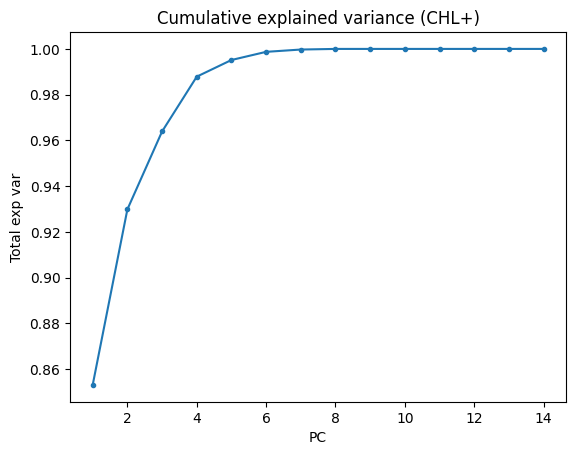

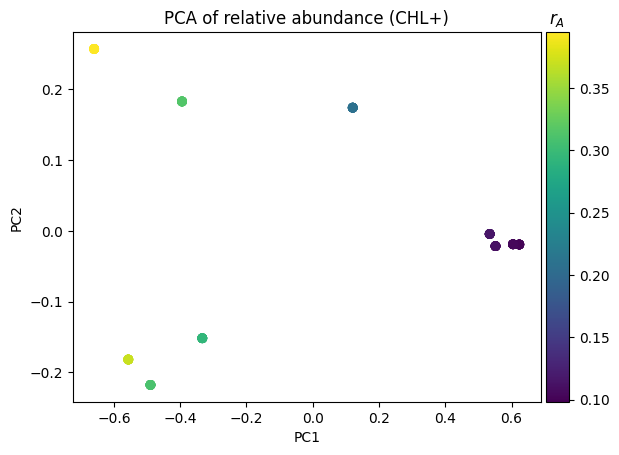

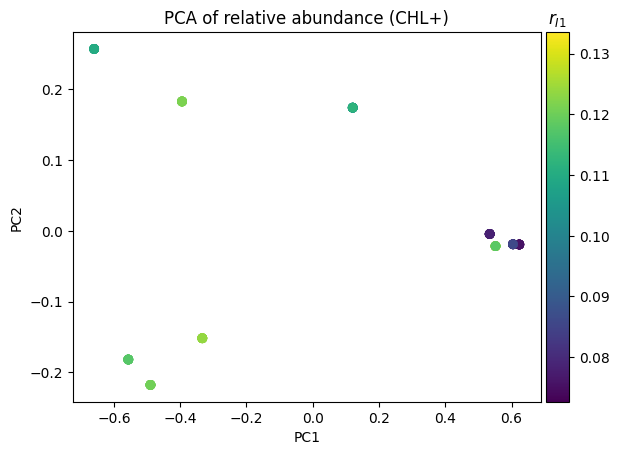

In [17]:
##############################################################################
### Apply PCA to the CHL+ data

MODEL = MODEL_CHL_POS
X = X_CHL_POS[:,X_SCREEN]
Y = Y_CHL_POS

# Run PCA
pca = PCA(n_components=X.shape[1])
pca.fit(X)

# Plot explained variance
fig, ax = plt.subplots(1, 1)
ax.plot(
    1 + np.arange(len(pca.explained_variance_ratio_)), 
    np.cumsum(pca.explained_variance_ratio_), ".-"
)
ax.set_xlabel(f"PC")
ax.set_ylabel(f"Total exp var")
ax.set_title(f"Cumulative explained variance (CHL+)")

plt.savefig(f"{IMGDIR}/scree_plot_chl_pos.png")

# Transform the data
X_PCA = pca.transform(X)

# Plots of transformed data in PC space, colored by each model parameter.
for pidx, param in enumerate(MODEL.get_inferred_param_names()):
    fig, ax = plt.subplots(1, 1)
    sc = ax.scatter(
        X_PCA[:,0], X_PCA[:,1], 
        c=Y[:,pidx],
    )
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(sc, cax=cax)
    cax.set_title(f"${texify(param)}$")

    ax.set_xlabel(f"PC1")
    ax.set_ylabel(f"PC2")
    ax.set_title(f"PCA of relative abundance (CHL+)")

    plt.savefig(f"{IMGDIR}/pca_chl_pos_{param}.png")

# Save the transformed data in PC space
np.save(
    f"{OUTDIR}/pca_transformed_data_chl_pos.npy", 
    X_PCA.reshape([*nar_rel_exp_chl_pos.shape[0:2], -1])
)


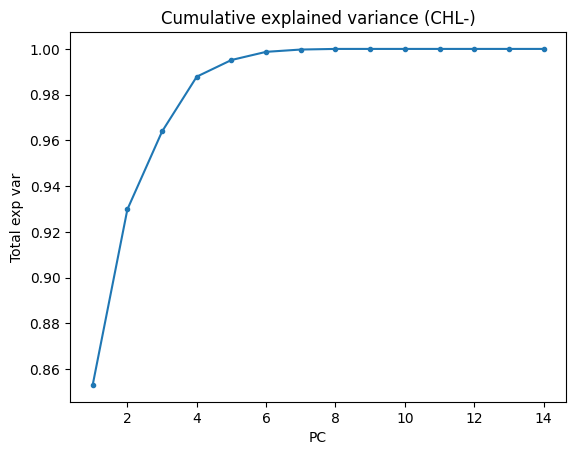

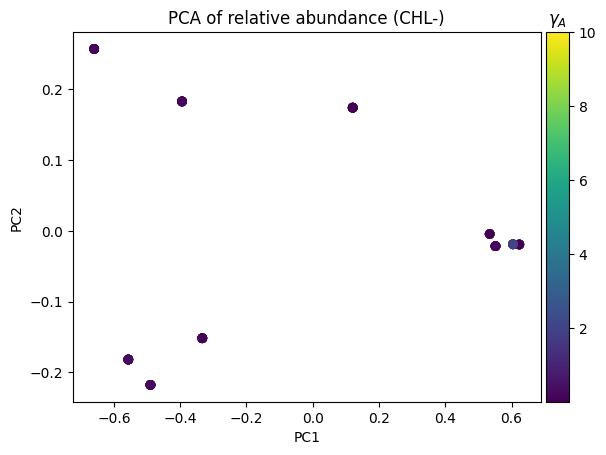

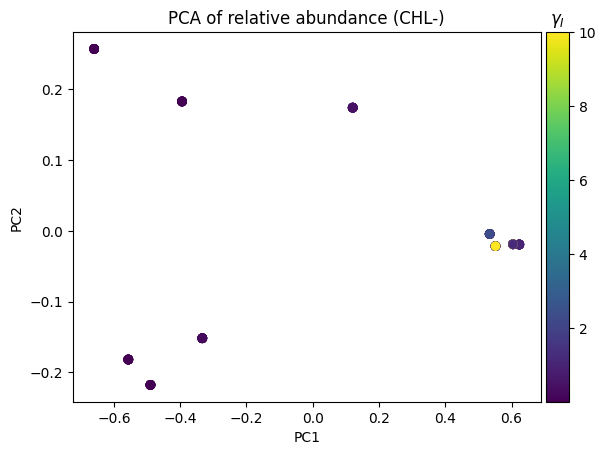

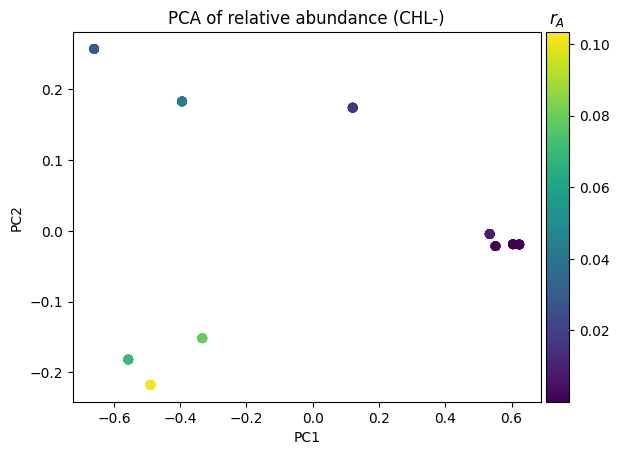

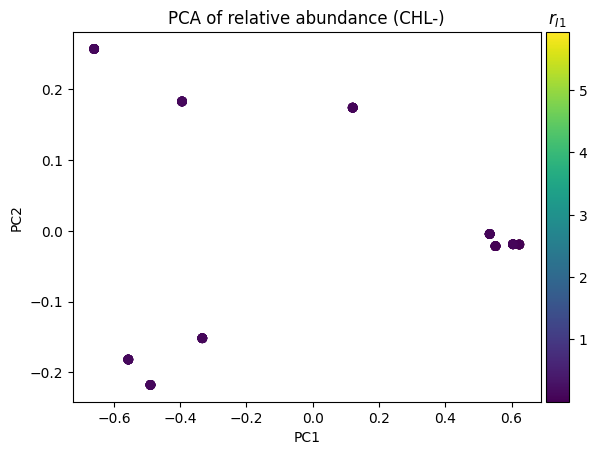

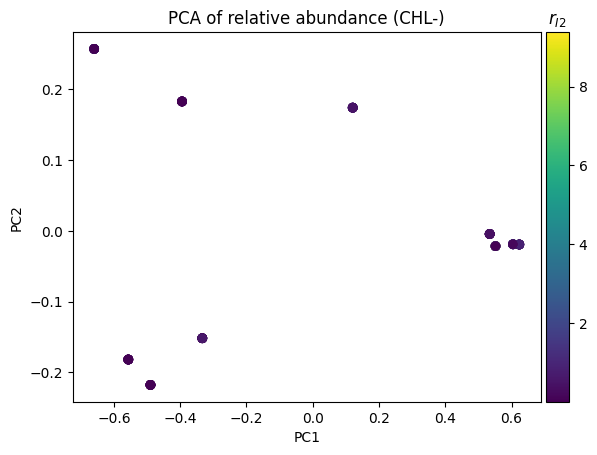

In [18]:
##############################################################################
### Apply PCA to the CHL- data

MODEL = MODEL_CHL_NEG
X = X_CHL_NEG[:,X_SCREEN]
Y = Y_CHL_NEG

# Run PCA
pca = PCA(n_components=X.shape[1])
pca.fit(X)

# Plot explained variance
fig_metabs, ax = plt.subplots(1, 1)
ax.plot(
    1 + np.arange(len(pca.explained_variance_ratio_)), 
    np.cumsum(pca.explained_variance_ratio_), ".-"
)
ax.set_xlabel(f"PC")
ax.set_ylabel(f"Total exp var")
ax.set_title(f"Cumulative explained variance (CHL-)")

plt.savefig(f"{IMGDIR}/scree_plot_chl_neg.png")

# Transform the data
X_PCA = pca.transform(X)

# Plots of transformed data in PC space, colored by each model parameter.
for pidx, param in enumerate(MODEL.get_inferred_param_names()):
    fig, ax = plt.subplots(1, 1)
    sc = ax.scatter(
        X_PCA[:,0], X_PCA[:,1], 
        c=Y[:,pidx],
    )
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(sc, cax=cax)
    cax.set_title(f"${texify(param)}$")

    ax.set_xlabel(f"PC1")
    ax.set_ylabel(f"PC2")
    ax.set_title(f"PCA of relative abundance (CHL-)")

    plt.savefig(f"{IMGDIR}/pca_chl_neg_{param}.png")

# Save the transformed data in PC space
np.save(
    f"{OUTDIR}/pca_transformed_data_chl_neg.npy", 
    X_PCA.reshape([*nar_rel_exp_chl_neg.shape[0:2], -1])
)


#### Lasso regression

Now, apply lasso to both cases individually.
We'll choose a random value of the regularization parameter $\alpha$ for the moment, and later use LOO cros validation to select an optimal value.
We will also retain the predicted outputs corresponding to each held-out sample, so that we can later compare the predicted *dynamics* with the actual dynamics.

In [19]:
##############################################################################
### Lasso for CHL+ case

X = X_CHL_POS[:,X_SCREEN]
Y = Y_CHL_POS

ALPHA = 0.01  # Regularization strength

clf = linear_model.Lasso(alpha=ALPHA, fit_intercept=FIT_INTERCEPT)
clf.fit(X, Y)

print("--------------------------------------------------")
print("CHL+")
print(f"Coefficients {clf.coef_.shape}:\n", clf.coef_)
# print(f"Intercepts: {clf.intercept_.shape}\n", clf.intercept_)
print("--------------------------------------------------")

##############################################################################
### Lasso for CHL- case

X = X_CHL_NEG[:,X_SCREEN]
Y = Y_CHL_NEG

ALPHA = 0.01  # Regularization strength

clf = linear_model.Lasso(alpha=ALPHA, fit_intercept=FIT_INTERCEPT)
clf.fit(X, Y)

print("--------------------------------------------------")
print("CHL-")
print(f"Coefficients {clf.coef_.shape}:\n", clf.coef_)
# print(f"Intercepts: {clf.intercept_.shape}\n", clf.intercept_)
print("--------------------------------------------------")

--------------------------------------------------
CHL+
Coefficients (2, 14):
 [[0.         0.         0.14976308 0.         0.         0.
  0.36178968 0.         0.24347833 0.         0.         0.
  0.         0.        ]
 [0.02610214 0.         0.         0.         0.         0.
  0.06053073 0.         0.13475182 0.         0.         0.
  0.         0.        ]]
--------------------------------------------------
--------------------------------------------------
CHL-
Coefficients (5, 14):
 [[ 0.95770183  0.          0.         -0.          0.          0.
  -0.09155998  0.         -0.          0.          0.         -0.
  -0.          2.36466237]
 [ 1.67534019  0.          0.         -0.          0.          0.
  -0.04704799 -0.          0.          0.          0.         -0.
   0.         -0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.01946646  0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.16554966  0.      

### Apply LOO cross validation to determine optimal alpha

In [20]:
# Range of alpha values to consider
alphas = np.logspace(-6, 1, 50)
print(f"alphas ({len(alphas)}):", alphas)

alphas (50): [1.00000000e-06 1.38949549e-06 1.93069773e-06 2.68269580e-06
 3.72759372e-06 5.17947468e-06 7.19685673e-06 1.00000000e-05
 1.38949549e-05 1.93069773e-05 2.68269580e-05 3.72759372e-05
 5.17947468e-05 7.19685673e-05 1.00000000e-04 1.38949549e-04
 1.93069773e-04 2.68269580e-04 3.72759372e-04 5.17947468e-04
 7.19685673e-04 1.00000000e-03 1.38949549e-03 1.93069773e-03
 2.68269580e-03 3.72759372e-03 5.17947468e-03 7.19685673e-03
 1.00000000e-02 1.38949549e-02 1.93069773e-02 2.68269580e-02
 3.72759372e-02 5.17947468e-02 7.19685673e-02 1.00000000e-01
 1.38949549e-01 1.93069773e-01 2.68269580e-01 3.72759372e-01
 5.17947468e-01 7.19685673e-01 1.00000000e+00 1.38949549e+00
 1.93069773e+00 2.68269580e+00 3.72759372e+00 5.17947468e+00
 7.19685673e+00 1.00000000e+01]


In [21]:
##############################################################################
### LOO cross validation for CHL+ case

MODEL = MODEL_CHL_POS
X = X_CHL_POS[:,X_SCREEN]
Y = Y_CHL_POS

nobs = len(X)
ydim = Y.shape[-1]
alpha_idx_to_rms_error = np.zeros([len(alphas), ydim])
alpha_idx_to_std_error = np.zeros([len(alphas), ydim])
for alpha_idx, alpha in tqdm.tqdm(enumerate(alphas), desc="alpha", total=len(alphas)):
    clf = linear_model.Lasso(alpha=alpha, fit_intercept=FIT_INTERCEPT)
    squared_errors = np.nan * np.ones([nobs, ydim])
    convergence_issue = False
    for exclude_idx in tqdm.trange(nobs, desc="LOO index", leave=False):
        # Subset the data, excluding one value
        screen = np.arange(nobs) != exclude_idx
        X_subset = X[screen,:]
        x_excluded = X[exclude_idx,:]
        Y_subset = Y[screen,:]
        y_excluded = Y[exclude_idx,:]

        # Apply lasso to the subset data, using the specified alpha value
        with warnings.catch_warnings():
            warnings.filterwarnings("error", category=ConvergenceWarning)
            try:
                clf.fit(X_subset, Y_subset)
                # Predict the value of the excluded datapoint
                y_pred = clf.predict(x_excluded[None,:]).flatten()
            except ConvergenceWarning as e:
                if not convergence_issue:
                    print(f"Convergence issue for alpha[{alpha_idx}]={alpha}")
                convergence_issue = True
                y_pred = np.nan * np.ones(ydim)

        # Compute squared deviations between prediction and target. Note that
        # this computation may include nan values, if fit did not converge.
        err = np.square(y_pred - y_excluded)
        squared_errors[exclude_idx] = err
    
    # Compute and store the RMSE and std dev for each target y value
    rmse = np.sqrt(np.mean(squared_errors, axis=0))
    stddeverr = np.std(squared_errors, axis=0)
    alpha_idx_to_rms_error[alpha_idx] = rmse
    alpha_idx_to_std_error[alpha_idx] = stddeverr

# Determine the optimal value of alpha for each target
optimal_alphas = np.nan * np.ones(ydim)
# Select minimizer alpha
optidxs = np.nanargmin(alpha_idx_to_rms_error, axis=0)
# Or select largest alpha with error within one SD of the minimizer's error
minalphaidxs = np.nanargmin(alpha_idx_to_rms_error, axis=0)
minalphas = alphas[minalphaidxs]
minalphas_err = alpha_idx_to_rms_error[minalphaidxs,np.arange(ydim)]
minalphas_std = alpha_idx_to_std_error[minalphaidxs,np.arange(ydim)]
thresh = minalphas_err + minalphas_std
screen_above_alpha = alphas[:,None] >= minalphas[None,:]
screen_low_error = (alpha_idx_to_rms_error < thresh)
screen = screen_above_alpha & screen_low_error
optidxs = len(alphas) - 1 - np.nanargmax(
    np.flip(screen_above_alpha & screen_low_error, axis=0), axis=0
)
optimal_alphas[:] = alphas[optidxs]

# Store optimal values for CHL+ case
optimal_alphas_chl_pos = optimal_alphas
alpha_idx_to_rms_error_chl_pos = alpha_idx_to_rms_error

print("Optimal alpha value for each model parameter:")
print(optimal_alphas_chl_pos)

alpha:   0%|          | 0/50 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[0]=1e-06


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[1]=1.389495494373139e-06


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[2]=1.9306977288832498e-06


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[3]=2.6826957952797274e-06


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[4]=3.727593720314938e-06


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[5]=5.179474679231212e-06


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[6]=7.196856730011514e-06


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[7]=1e-05


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[11]=3.727593720314938e-05


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[12]=5.1794746792312125e-05


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Optimal alpha value for each model parameter:
[2.68269580e-05 1.93069773e-05]


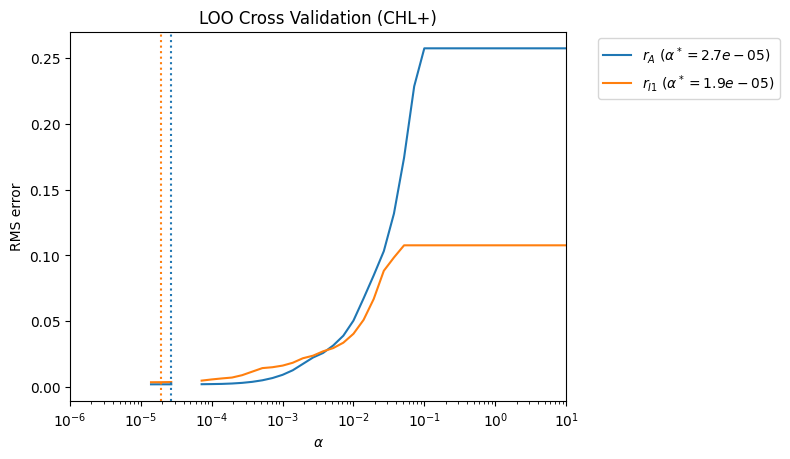

In [22]:
##############################################################################
##  Plot LOOCV results for CHL+ case

MODEL = MODEL_CHL_POS
optimal_alphas = optimal_alphas_chl_pos
alpha_idx_to_rms_error = alpha_idx_to_rms_error_chl_pos

fig, ax = plt.subplots(1, 1)
lines = ax.semilogx(
    alphas, alpha_idx_to_rms_error, 
    label=[
        f"${texify(s)}$ ($\\alpha^*={v:.2g}$)" for s, v 
        in zip(MODEL.get_inferred_param_names(), optimal_alphas)
    ],
)
ax.legend()
ax.set_xlabel(f"$\\alpha$")
ax.set_ylabel(f"RMS error")
ax.set_title(f"LOO Cross Validation (CHL+)")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlim(alphas.min(), alphas.max())
ylims = ax.get_ylim()
ax.vlines(
    optimal_alphas, *ylims, 
    linestyle=":", 
    colors=[l.get_color() for l in lines]
)
ax.set_ylim(*ylims)

plt.savefig(f"{IMGDIR}/loocv_chl_pos.png")


In [23]:
##############################################################################
### LOO cross validation for CHL- case

MODEL = MODEL_CHL_NEG
X = X_CHL_NEG[:,X_SCREEN]
Y = Y_CHL_NEG

nobs = len(X)
ydim = Y.shape[-1]
alpha_idx_to_rms_error = np.zeros([len(alphas), ydim])
alpha_idx_to_std_error = np.zeros([len(alphas), ydim])
for alpha_idx, alpha in tqdm.tqdm(enumerate(alphas), desc="alpha", total=len(alphas)):
    clf = linear_model.Lasso(alpha=alpha, fit_intercept=FIT_INTERCEPT)
    squared_errors = np.nan * np.ones([nobs, ydim])
    convergence_issue = False
    for exclude_idx in tqdm.trange(nobs, desc="LOO index", leave=False):
        # Subset the data, excluding one value
        screen = np.arange(nobs) != exclude_idx
        X_subset = X[screen,:]
        x_excluded = X[exclude_idx,:]
        Y_subset = Y[screen,:]
        y_excluded = Y[exclude_idx,:]

        # Apply lasso to the subset data, using the specified alpha value
        with warnings.catch_warnings():
            warnings.filterwarnings("error", category=ConvergenceWarning)
            try:
                clf.fit(X_subset, Y_subset)
                # Predict the value of the excluded datapoint
                y_pred = clf.predict(x_excluded[None,:]).flatten()
            except ConvergenceWarning as e:
                if not convergence_issue:
                    print(f"Convergence issue for alpha[{alpha_idx}]={alpha}")
                convergence_issue = True
                y_pred = np.nan * np.ones(ydim)

        # Compute squared deviations between prediction and target. Note that
        # this computation may include nan values, if fit did not converge.
        err = np.square(y_pred - y_excluded)
        squared_errors[exclude_idx] = err
    
    # Compute and store the RMSE and std dev for each target y value
    rmse = np.sqrt(np.mean(squared_errors, axis=0))
    stddeverr = np.std(squared_errors, axis=0)
    alpha_idx_to_rms_error[alpha_idx] = rmse
    alpha_idx_to_std_error[alpha_idx] = stddeverr

# Determine the optimal value of alpha for each target
optimal_alphas = np.nan * np.ones(ydim)
# Select minimizer alpha
optidxs = np.nanargmin(alpha_idx_to_rms_error, axis=0)
# Or select largest alpha with error within one SD of the minimizer's error
minalphaidxs = np.nanargmin(alpha_idx_to_rms_error, axis=0)
minalphas = alphas[minalphaidxs]
minalphas_err = alpha_idx_to_rms_error[minalphaidxs,np.arange(ydim)]
minalphas_std = alpha_idx_to_std_error[minalphaidxs,np.arange(ydim)]
thresh = minalphas_err + minalphas_std
screen_above_alpha = alphas[:,None] >= minalphas[None,:]
screen_low_error = (alpha_idx_to_rms_error < thresh)
screen = screen_above_alpha & screen_low_error
optidxs = len(alphas) - 1 - np.nanargmax(
    np.flip(screen_above_alpha & screen_low_error, axis=0), axis=0
)
optimal_alphas[:] = alphas[optidxs]

# Store optimal values for CHL+ case
optimal_alphas_chl_neg = optimal_alphas
alpha_idx_to_rms_error_chl_neg = alpha_idx_to_rms_error

print("Optimal alpha value for each model parameter:")
print(optimal_alphas_chl_neg)

alpha:   0%|          | 0/50 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[0]=1e-06


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[1]=1.389495494373139e-06


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[2]=1.9306977288832498e-06


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[3]=2.6826957952797274e-06


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[4]=3.727593720314938e-06


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[5]=5.179474679231212e-06


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[6]=7.196856730011514e-06


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[7]=1e-05


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[8]=1.3894954943731361e-05


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[9]=1.9306977288832496e-05


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[10]=2.6826957952797274e-05


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[11]=3.727593720314938e-05


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[12]=5.1794746792312125e-05


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[13]=7.196856730011514e-05


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[14]=0.0001


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[15]=0.00013894954943731373


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[16]=0.00019306977288832496


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[17]=0.00026826957952797245


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[18]=0.0003727593720314938


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[19]=0.0005179474679231208


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[20]=0.0007196856730011514


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[21]=0.001


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[22]=0.0013894954943731374


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Convergence issue for alpha[23]=0.0019306977288832496


LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

LOO index:   0%|          | 0/110 [00:00<?, ?it/s]

Optimal alpha value for each model parameter:
[1.0000000e+01 1.0000000e+01 2.6826958e-03 1.0000000e+01 1.0000000e+01]


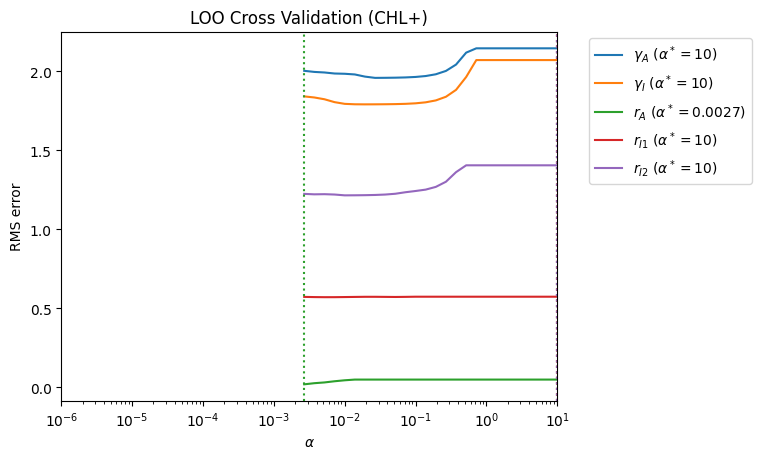

In [24]:
##############################################################################
##  Plot LOOCV results for CHL- case

MODEL = MODEL_CHL_NEG
optimal_alphas = optimal_alphas_chl_neg
alpha_idx_to_rms_error = alpha_idx_to_rms_error_chl_neg

fig, ax = plt.subplots(1, 1)
lines = ax.semilogx(
    alphas, alpha_idx_to_rms_error, 
    label=[
        f"${texify(s)}$ ($\\alpha^*={v:.2g}$)" for s, v 
        in zip(MODEL.get_inferred_param_names(), optimal_alphas)
    ],
)
ax.legend()
ax.set_xlabel(f"$\\alpha$")
ax.set_ylabel(f"RMS error")
ax.set_title(f"LOO Cross Validation (CHL+)")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlim(alphas.min(), alphas.max())
ylims = ax.get_ylim()
ax.vlines(
    optimal_alphas, *ylims, 
    linestyle=":", 
    colors=[l.get_color() for l in lines]
)
ax.set_ylim(*ylims)

plt.savefig(f"{IMGDIR}/loocv_chl_neg.png")


## Model evaluation

We can now specify a more optimal choice of $\alpha$, apply lasso using that value, and evaluate the resulting fit.

In [25]:
##############################################################################
##  Apply lasso using each optimal alpha for CHL+

MODEL = MODEL_CHL_POS
X = X_CHL_POS[:,X_SCREEN]
Y = Y_CHL_POS
fixed_params = FIXED_PARAMS_CHL_POS
optimal_alphas = optimal_alphas_chl_pos

inf_param_names = MODEL.get_inferred_param_names()

num_alphas = len(optimal_alphas)
nobs = len(X)
ydim = Y.shape[-1]
predicted_ys = np.nan * np.ones([nobs, ydim])
best_coeffs = np.nan * np.ones([ydim, X.shape[-1]])
best_intercepts = np.nan * np.ones(ydim)
for i, (param_name, alpha) in enumerate(zip(inf_param_names, optimal_alphas)):
    print(f"alpha={alpha:.6g} (optimal for {param_name})")
    clf = linear_model.Lasso(alpha=alpha, fit_intercept=FIT_INTERCEPT)
    clf.fit(X, Y)
    coeffs = clf.coef_
    intercepts = clf.intercept_
    num_zero_coeffs = np.sum(coeffs == 0, axis=1)
    predicted_ys[:,i] = clf.predict(X)[:,i]
    best_coeffs[i,:] = coeffs[i,:]
    best_intercepts[i] = intercepts if not FIT_INTERCEPT else intercepts[i]
    print("Number of 0 coeffs:", num_zero_coeffs)
    print("Coefficients:\n", best_coeffs[i])
    print("Intercept:\n", best_intercepts[i])
    print("---------------------------------------------------------")

predicted_ys_chl_pos = predicted_ys.reshape(
    [len(NATIVE_IDXS), -1, ydim]
)

best_coeffs_chl_pos = best_coeffs
best_intercepts_chl_pos = best_intercepts

np.save(
    f"{OUTDIR}/optimal_alphas_chl_pos.npy", 
    optimal_alphas
)
np.save(
    f"{OUTDIR}/predicted_model_params_chl_pos.npy", 
    predicted_ys_chl_pos
)
np.save(f"{OUTDIR}/coeffs_chl_pos.npy", best_coeffs)
np.save(f"{OUTDIR}/intercepts_chl_pos.npy", best_intercepts)

alpha=2.6827e-05 (optimal for r_A)
Number of 0 coeffs: [9 6]
Coefficients:
 [ 0.09749235  0.          0.3978882   0.19614014  0.          0.
  0.39892797  0.          0.00585758  0.          0.          0.
 -0.          0.        ]
Intercept:
 0.0
---------------------------------------------------------
alpha=1.9307e-05 (optimal for r_I1)
Number of 0 coeffs: [8 7]
Coefficients:
 [ 0.0360479   0.          0.03611083  0.          0.          0.
  0.02705771 -0.          0.02044037  0.          0.19768211  0.44682468
  0.         -0.10207769]
Intercept:
 0.0
---------------------------------------------------------


In [26]:
##############################################################################
##  Apply lasso using each optimal alpha for CHL-

MODEL = MODEL_CHL_NEG
X = X_CHL_NEG[:,X_SCREEN]
Y = Y_CHL_NEG
fixed_params = FIXED_PARAMS_CHL_NEG
optimal_alphas = optimal_alphas_chl_neg

inf_param_names = MODEL.get_inferred_param_names()

num_alphas = len(optimal_alphas)
nobs = len(X)
ydim = Y.shape[-1]
predicted_ys = np.nan * np.ones([nobs, ydim])
best_coeffs = np.nan * np.ones([ydim, X.shape[-1]])
best_intercepts = np.nan * np.ones(ydim)
for i, (param_name, alpha) in enumerate(zip(inf_param_names, optimal_alphas)):
    print(f"alpha={alpha:.6g} (optimal for {param_name})")
    clf = linear_model.Lasso(alpha=alpha, fit_intercept=FIT_INTERCEPT)
    clf.fit(X, Y)
    coeffs = clf.coef_
    intercepts = clf.intercept_
    num_zero_coeffs = np.sum(coeffs == 0, axis=1)
    predicted_ys[:,i] = clf.predict(X)[:,i]
    best_coeffs[i,:] = coeffs[i,:]
    best_intercepts[i] = intercepts if not FIT_INTERCEPT else intercepts[i]
    print("Number of 0 coeffs:", num_zero_coeffs)
    print("Coefficients:\n", best_coeffs[i])
    print("Intercept:\n", best_intercepts[i])
    print("---------------------------------------------------------")

predicted_ys_chl_neg = predicted_ys.reshape(
    [len(NATIVE_IDXS), -1, ydim]
)

best_coeffs_chl_neg = best_coeffs
best_intercepts_chl_neg = best_intercepts

np.save(
    f"{OUTDIR}/optimal_alphas_chl_neg.npy", 
    optimal_alphas
)
np.save(
    f"{OUTDIR}/predicted_model_params_chl_neg.npy", 
    predicted_ys_chl_neg
)
np.save(f"{OUTDIR}/coeffs_chl_neg.npy", best_coeffs)
np.save(f"{OUTDIR}/intercepts_chl_neg.npy", best_intercepts)

alpha=10 (optimal for gamma_A)
Number of 0 coeffs: [14 14 14 14 14]
Coefficients:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Intercept:
 0.0
---------------------------------------------------------
alpha=10 (optimal for gamma_I)
Number of 0 coeffs: [14 14 14 14 14]
Coefficients:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Intercept:
 0.0
---------------------------------------------------------
alpha=0.0026827 (optimal for r_A)
Number of 0 coeffs: [ 8  7 10 10  8]
Coefficients:
 [0.         0.         0.08977467 0.06081576 0.         0.
 0.01098293 0.         0.01300571 0.         0.         0.
 0.         0.        ]
Intercept:
 0.0
---------------------------------------------------------
alpha=10 (optimal for r_I1)
Number of 0 coeffs: [14 14 14 14 14]
Coefficients:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Intercept:
 0.0
---------------------------------------------------------
alpha=10 (optimal for r_I2)
Number of 0 coeffs: [14 14 14 14 14]
Coefficients:
 [0. 0. 0. 0. 0. 0.

native:   0%|          | 0/10 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

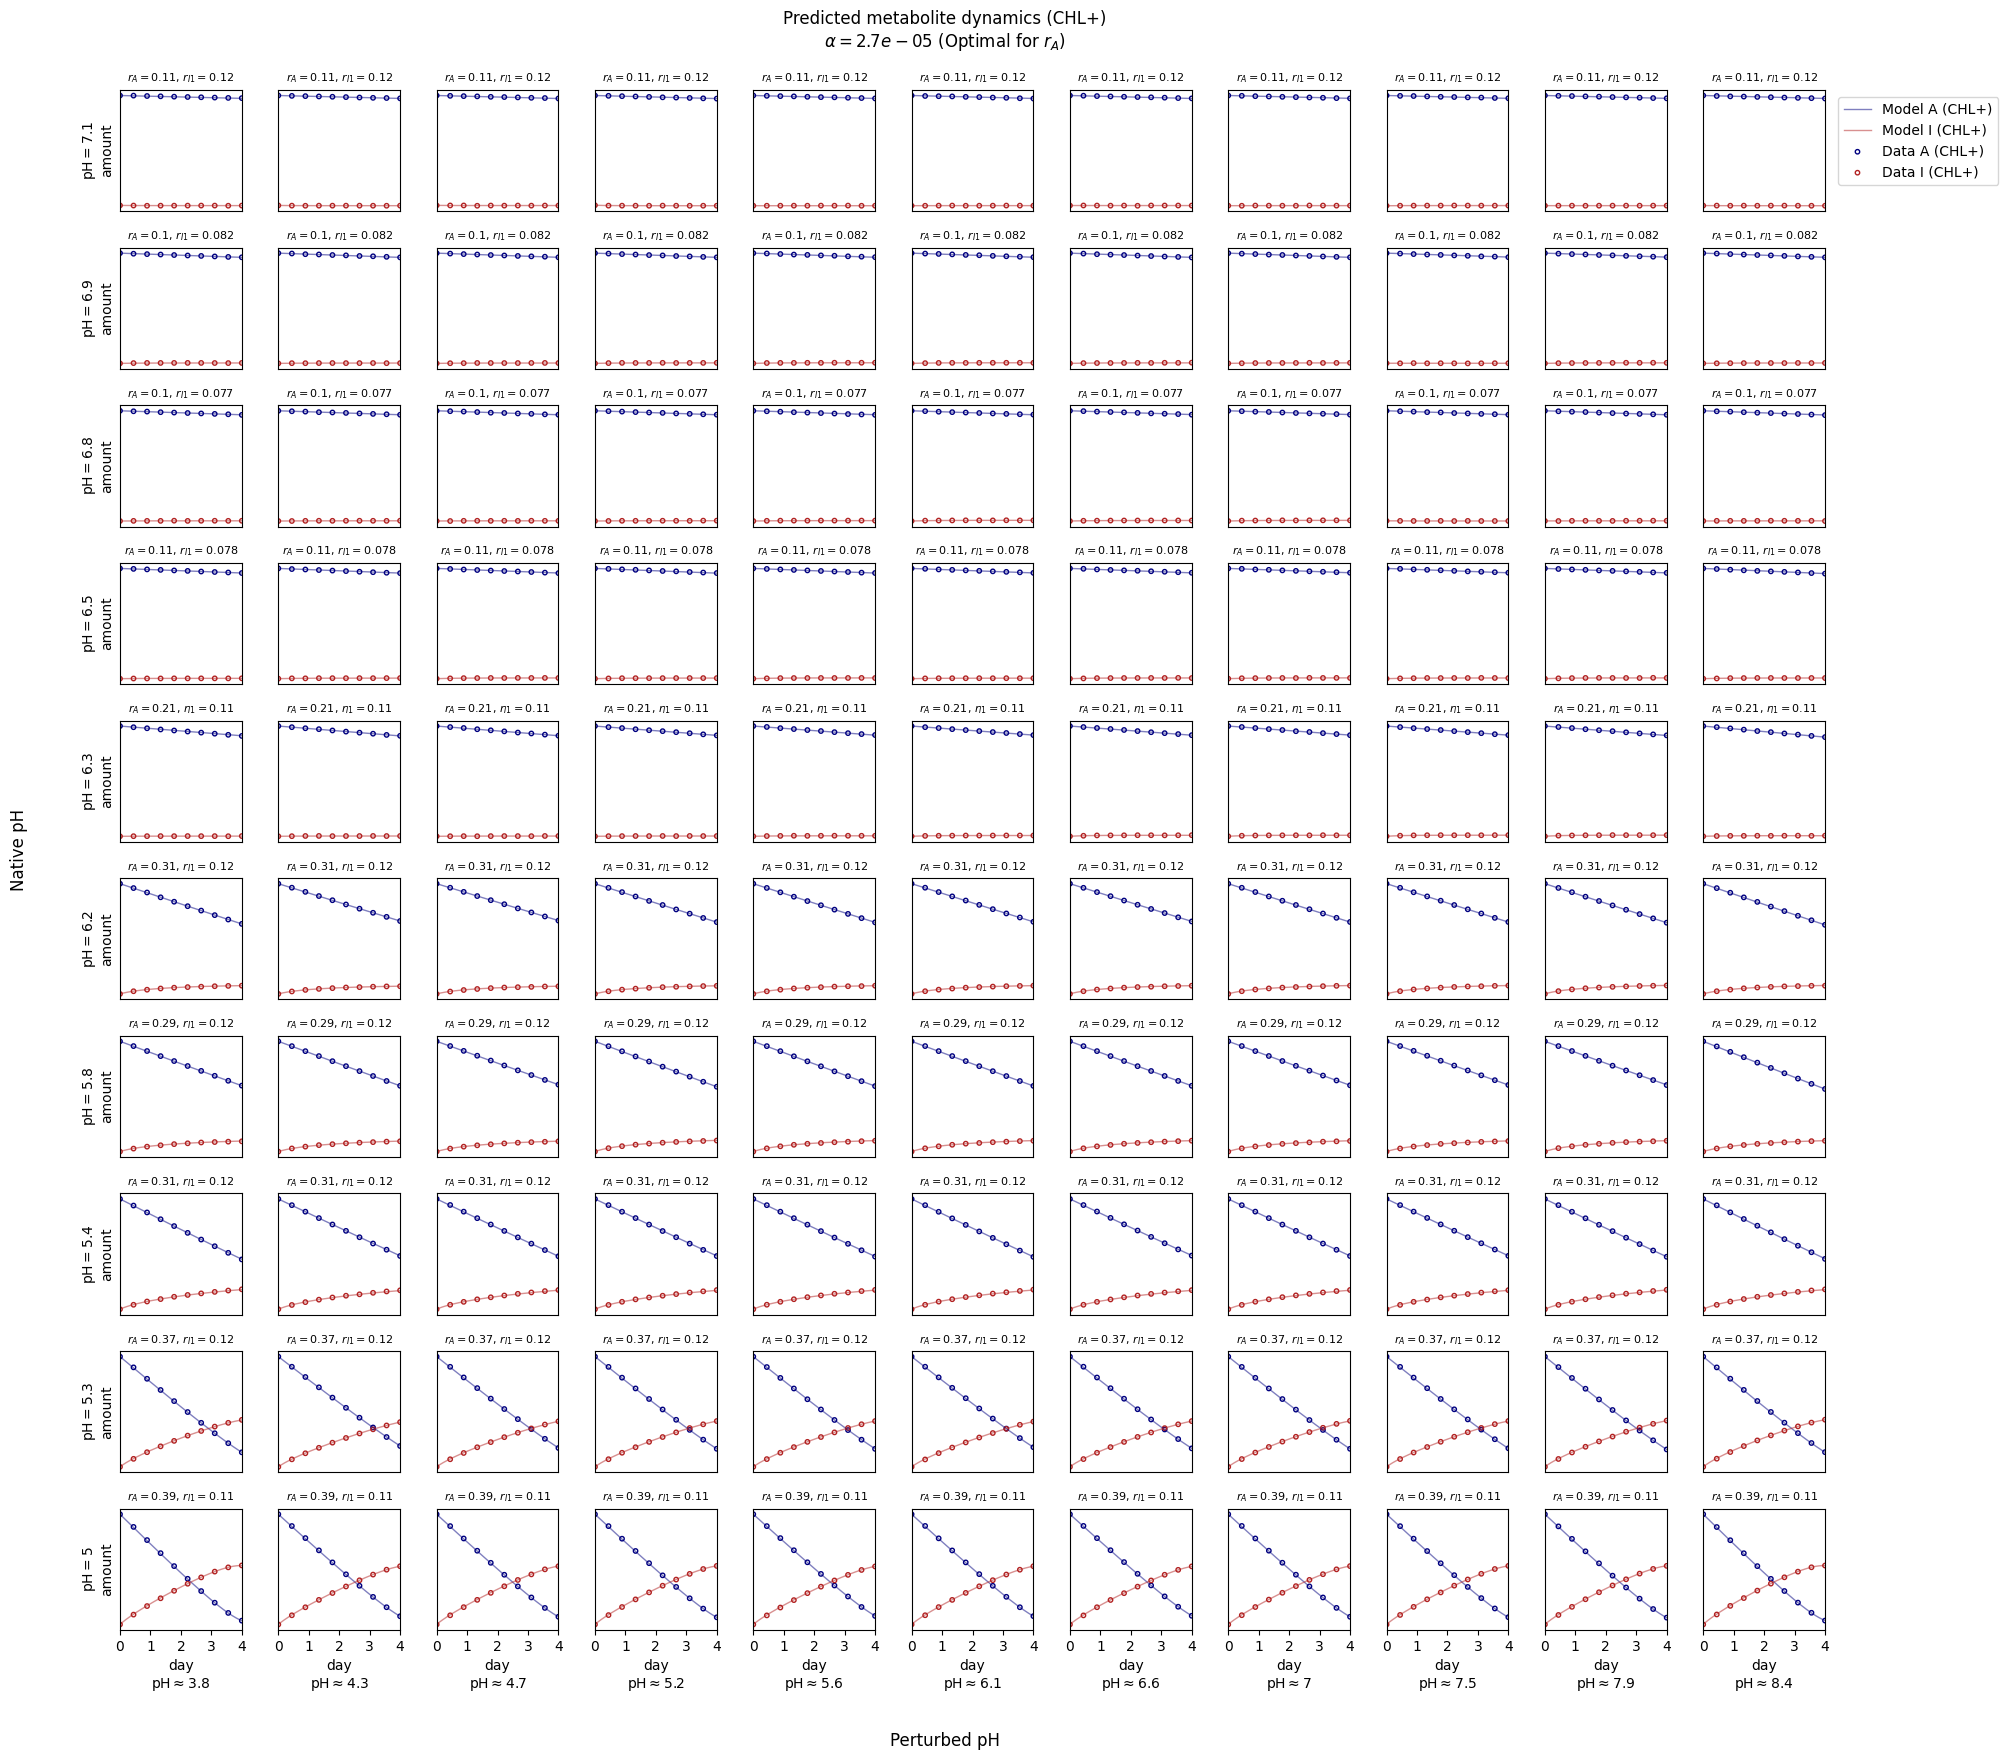

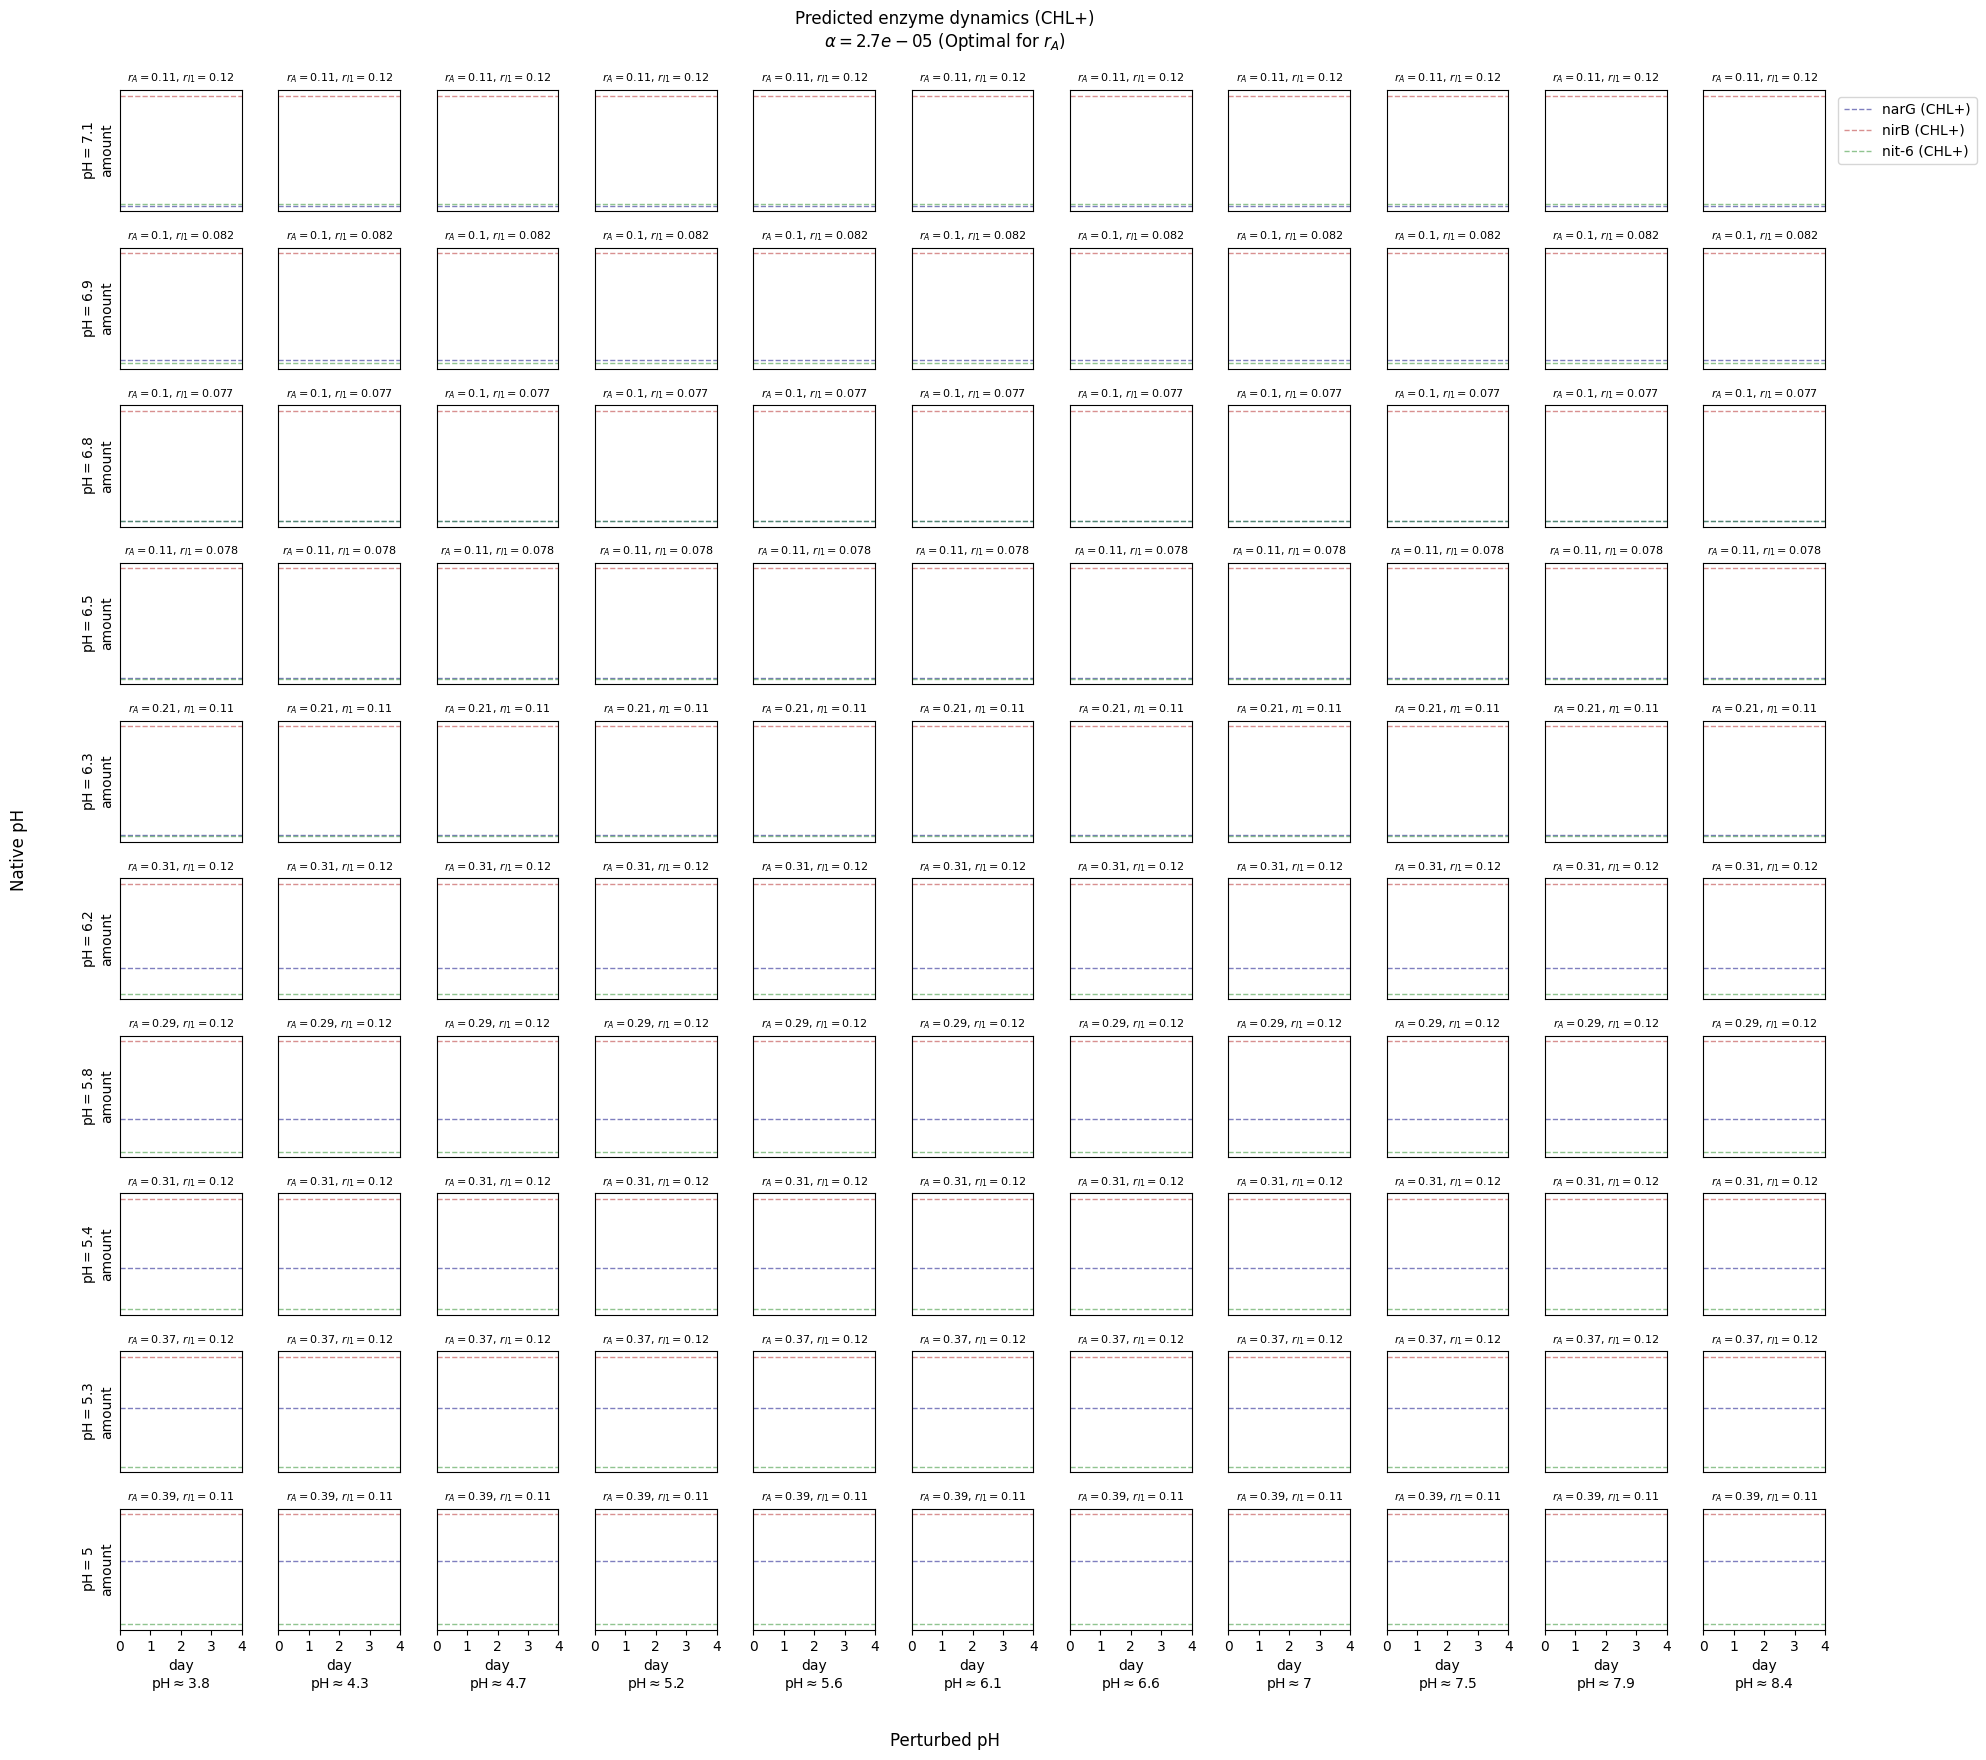

native:   0%|          | 0/10 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

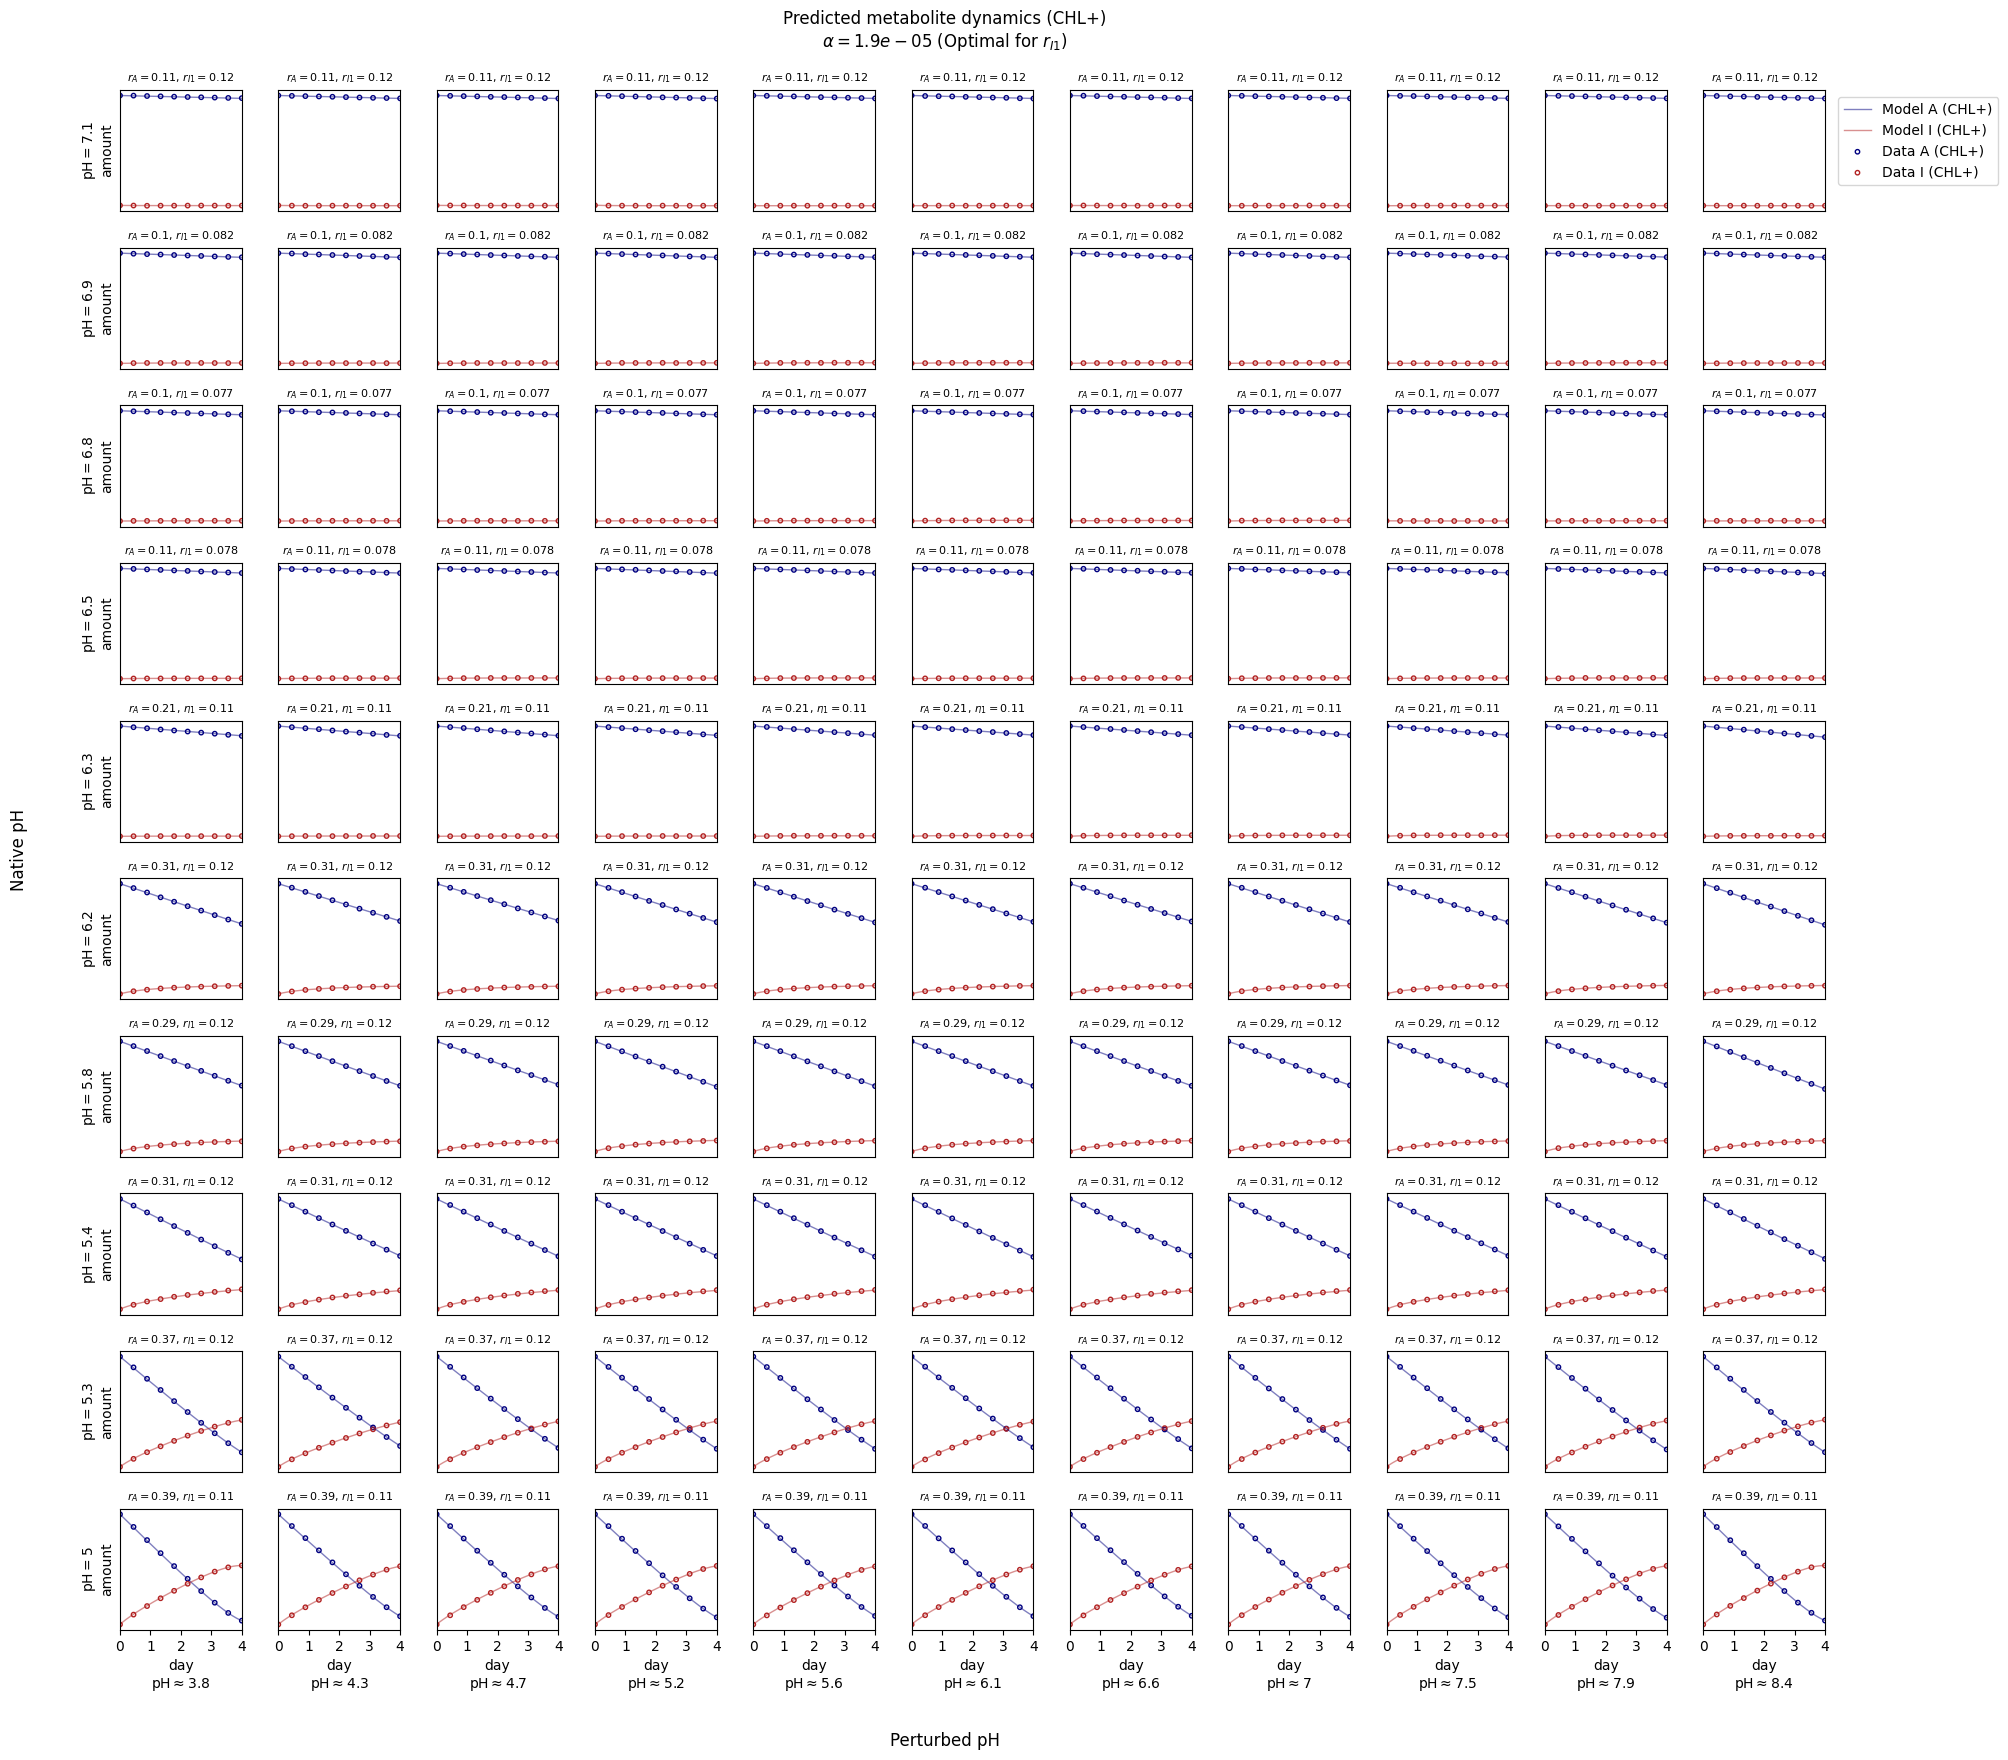

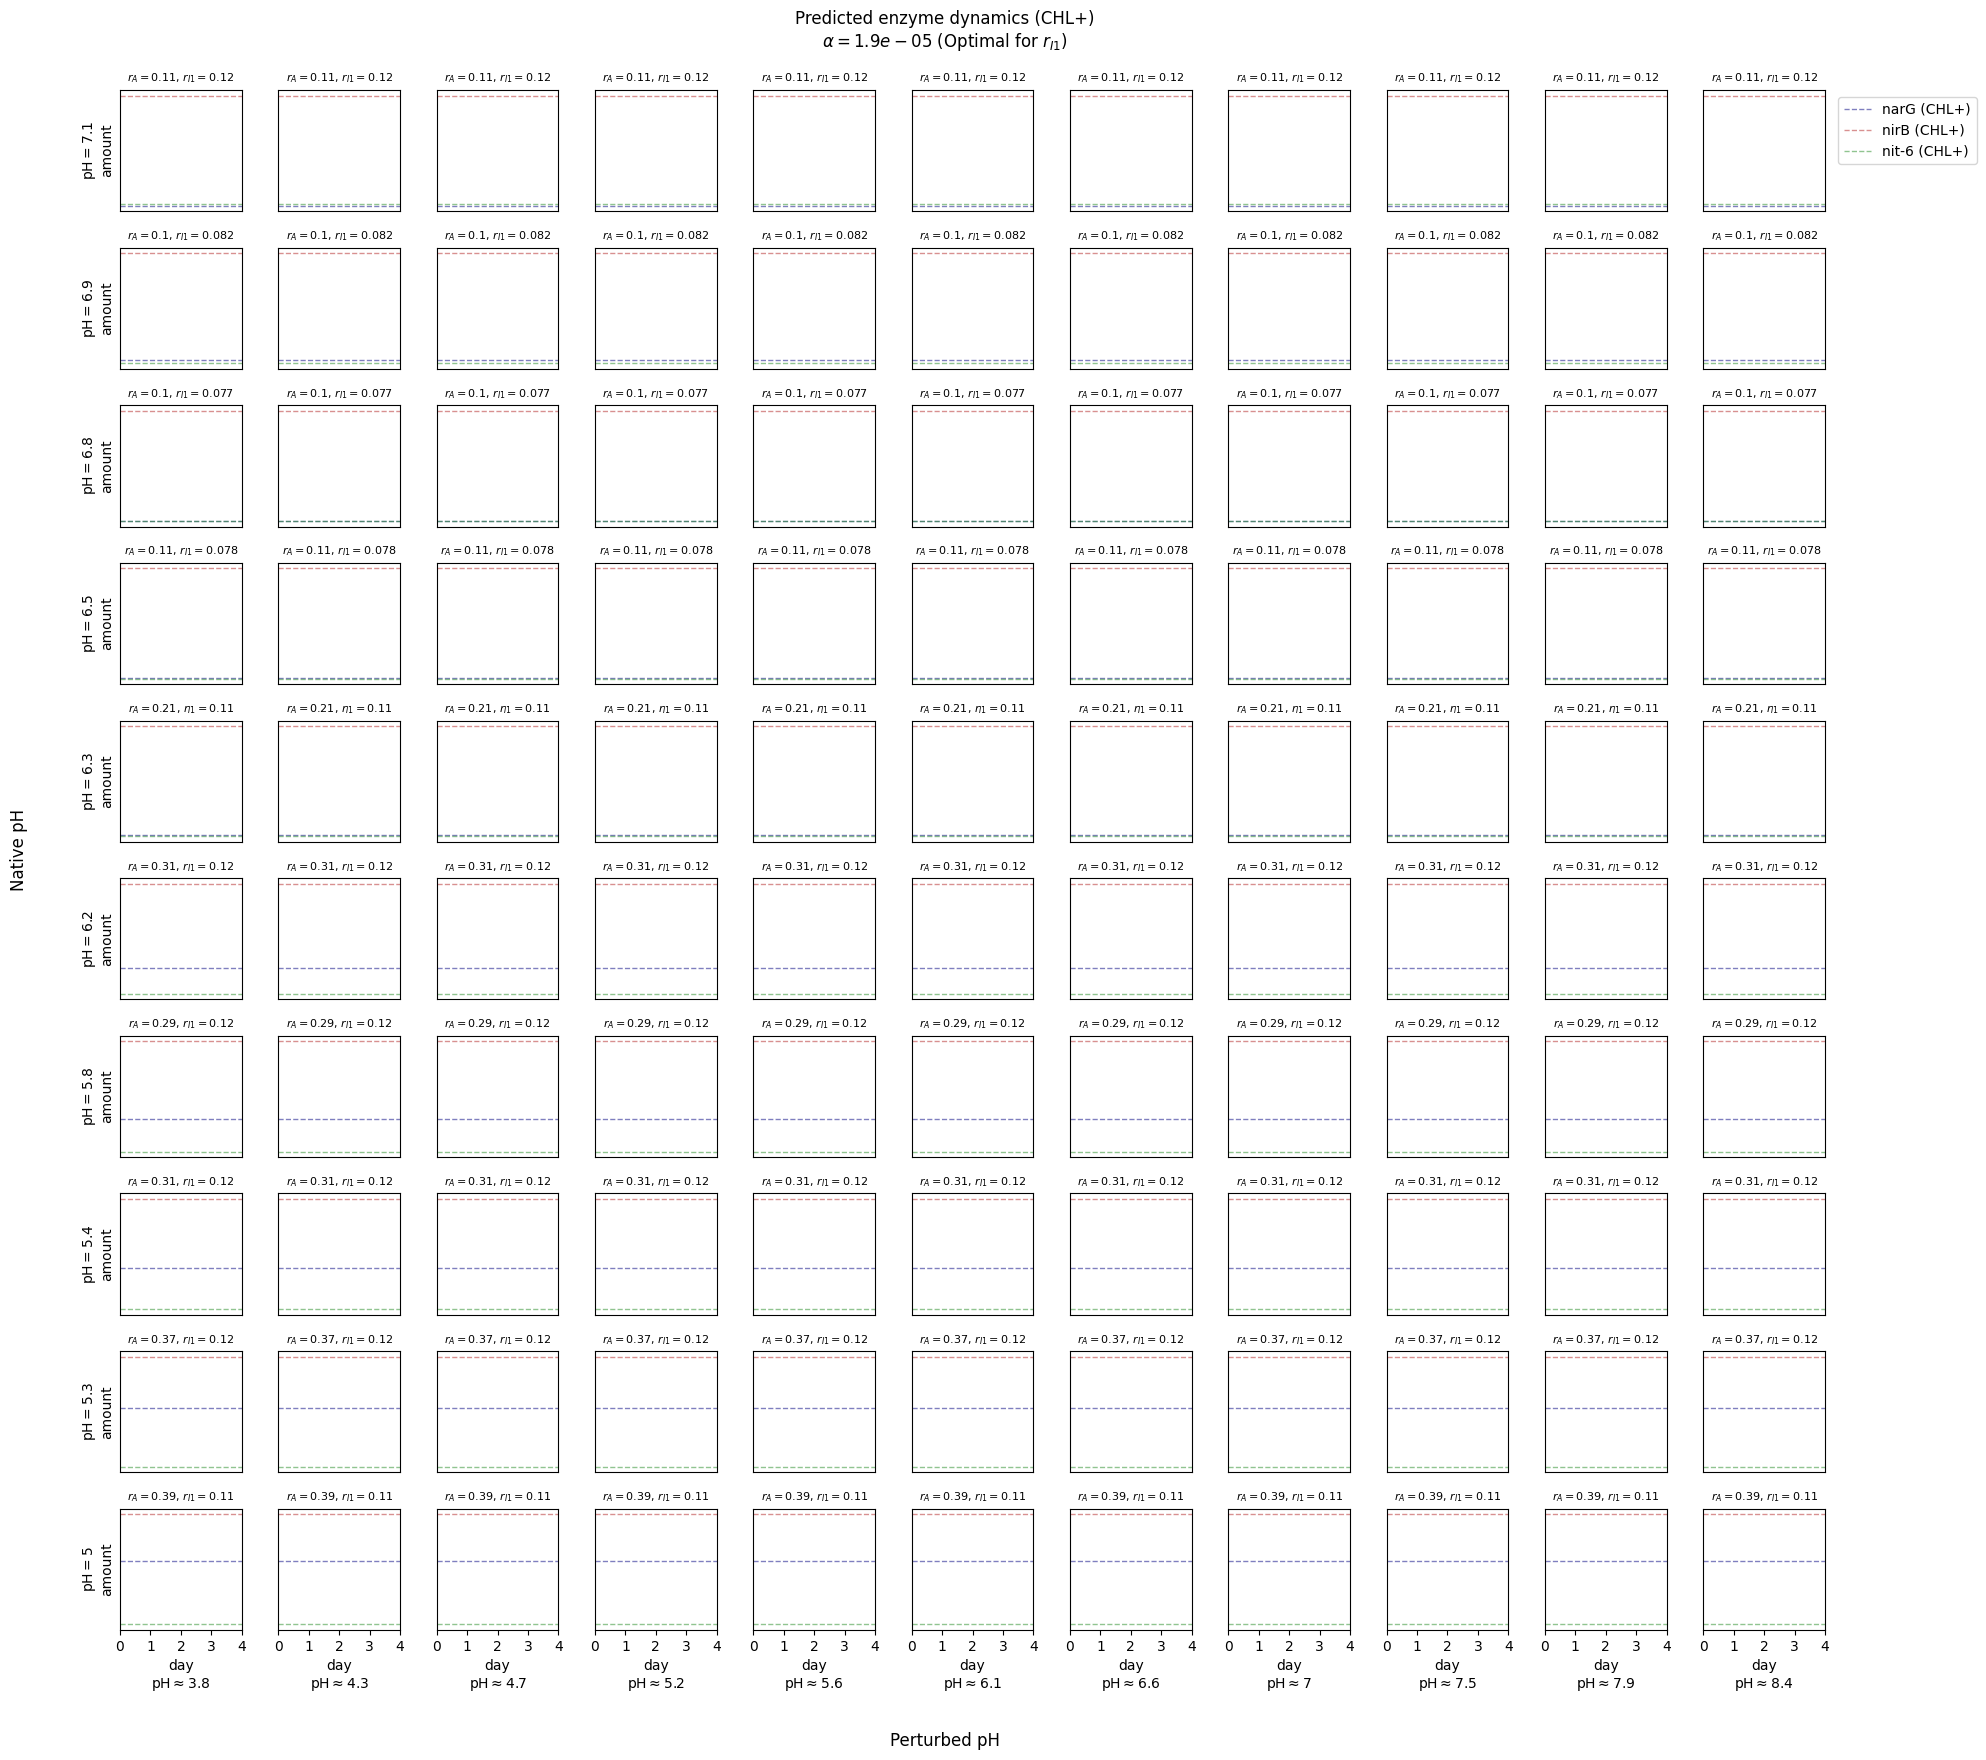

In [27]:
##############################################################################
##  Plot dynamics corresponding to predictions (CHL+)

MODEL = MODEL_CHL_POS
optimal_alphas = optimal_alphas_chl_pos
predicted_ys = predicted_ys_chl_pos

# Timestepping
dt = 0.05
T = 9
N = int(T/dt)

indices = np.linspace(0, int(9/dt-1), 10).astype(int)
plot_t = np.linspace(0, 9, N)
plot_t_scatter = np.linspace(0, 9, 10)

inf_param_names = MODEL.get_inferred_param_names()
for alpha_idx, (param_name, alpha) in enumerate(zip(inf_param_names, optimal_alphas)):
    fig_metabs, axs_metabs = plt.subplots(10, 11, figsize=(22, 20))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    fig_enzyme, axs_enzyme = plt.subplots(10, 11, figsize=(22, 20))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    for native in tqdm.trange(10, desc="native", leave=False):
        for pert in tqdm.trange(11, desc="perturbed", leave=False):
            # Get LOO predicted parameters
            y_pred = predicted_ys[9-native, pert, :]

            # Scaled initial and final enzyme levels
            scale = nir_t0[9 - native, pert]
            x1_0 = nar_t0[9 - native, pert]/scale
            x2_0 = 1
            x3_0 = nit_t0[9 - native, pert]/scale
            x1_f = nar_t9_none[9 - native, pert]
            x2_f = nir_t9_none[9 - native, pert]
            x3_f = nit_t9_none[9 - native, pert]
            
            # Collect soil samples for the native/perturbed sample
            sample = samples_from_soils(soils[9 - native])[pert]
            
            # Load functional data for the CHL+ case
            function = syn_functional_data_chl_pos[9-native, pert, :, :]
            A_data_drug = function[3,:]
            I_data_drug = function[4,:]
            y_data_drug = np.concatenate([A_data_drug, I_data_drug])
            
            # Plot the inferred model (CHL+)
            y0 = np.array([x1_0, x2_0, x3_0, A_data_drug[0], I_data_drug[0]])
            params = {
                p: y_pred[i] for i, p 
                in enumerate(MODEL_CHL_POS.get_inferred_param_names())
            }
            x1, x2, x3, A, I = MODEL_CHL_POS.simulate(y0, params, dt, T)

        
            # Plot metabolites (CHL+)
            ax = axs_metabs[native, pert]
            ax.plot(
                plot_t, A, 
                color='navy', alpha=0.5, linewidth=1, 
                label="Model A (CHL+)"
            )
            ax.plot(
                plot_t, I, 
                color='firebrick', alpha=0.5, linewidth=1,
                label="Model I (CHL+)"
            )
            ax.scatter(
                plot_t_scatter, A_data_drug, 
                color='navy', s=10, facecolors='none',
                label="Data A (CHL+)"
            )
            ax.scatter(
                plot_t_scatter, I_data_drug, 
                color='firebrick', s=10, facecolors='none',
                label="Data I (CHL+)"
            )

            # Plot enzymes (CHL+)
            ax = axs_enzyme[native, pert]
            ax.plot(
                plot_t, x1, 
                color='navy', alpha=0.5, linewidth=1, linestyle='--',
                label="narG (CHL+)"
            )
            ax.plot(
                plot_t, x2, 
                color='firebrick', alpha=0.5, linewidth=1, linestyle='--',
                label="nirB (CHL+)"
            )
            ax.plot(
                plot_t, x3, 
                color='forestgreen', alpha=0.5, linewidth=1, linestyle='--',
                label="nit-6 (CHL+)"
            )

            for ax in [axs_metabs[native, pert], axs_enzyme[native, pert]]:
                axtitle = ", ".join(
                    [f"${texify(p)}={y_pred[i]:.2g}$" for i, p 
                     in enumerate(MODEL_CHL_POS.get_inferred_param_names())]
                )
                ax.set_title(axtitle, fontsize=8)
                ax.set_xlim(0, 9)
                ax.set_yticks([])
                if native == 0 and pert == 10:
                    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                if pert == 0:
                    ax.set_ylabel(f"pH$=${NATIVE_PHS[9 - native]:.2g}\namount")
                if native == 9:
                    ax.set_xticks(
                        np.linspace(0, 9, 5, endpoint=True), 
                        labels=[str(i) for i in range(5)]
                    )
                    ax.set_xlabel(f"day\npH$\\approx${PERTURBED_PHS[pert]:.2g}")
                else:
                    ax.set_xticks([])
    
    title = "Predicted metabolite dynamics (CHL+)"
    subtitle = f"$\\alpha={alpha:.2g}$ (Optimal for ${texify(param_name)}$)"
    fig_metabs.supxlabel("Perturbed pH", y=0.05)
    fig_metabs.supylabel("Native pH", x=0.075)
    fig_metabs.suptitle(
        title + "\n" + subtitle if subtitle else title,
        y=0.92,
    )

    title = "Predicted enzyme dynamics (CHL+)"
    subtitle = f"$\\alpha={alpha:.2g}$ (Optimal for ${texify(param_name)}$)"
    fig_enzyme.supxlabel("Perturbed pH", y=0.05)
    fig_enzyme.supylabel("Native pH", x=0.075)
    fig_enzyme.suptitle(
        title + "\n" + subtitle if subtitle else title,
        y=0.92,
    )

    plt.figure(fig_metabs)
    plt.savefig(f"{IMGDIR}/alpha_{alpha_idx}_model_vs_data_metabolites.png")
    plt.figure(fig_enzyme)
    plt.savefig(f"{IMGDIR}/alpha_{alpha_idx}_model_vs_data_enzymes.png")
    plt.show()

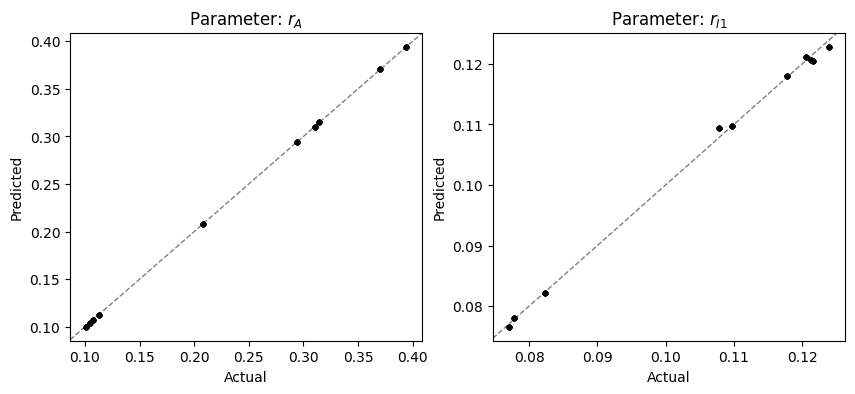

In [28]:
##############################################################################
##  Plot actual vs predicted parameter values (CHL+)

model = MODEL_CHL_POS
nparams = NPARAMS_CHL_POS
params_true = syn_model_params_chl_pos
params_pred = predicted_ys_chl_pos

fig, axes = plt.subplots(1, nparams, figsize=(5*nparams, 4))

for i, ax in enumerate(axes):
    param_name = model.get_inferred_param_names()[i]
    ax.plot(
        params_true[:,:,i].flatten(), params_pred[:,:,i].flatten(),
        marker=".",
        linestyle="None",
        color="k"
    )
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    xs = np.linspace(*xlims, 10)
    ax.plot(xs, xs, "--k", linewidth=1, alpha=0.5)
    ax.set_xlim(*xlims)
    ax.set_ylim(*ylims)
    ax.set_xlabel(f"Actual")
    ax.set_ylabel(f"Predicted")
    ax.set_title(f"Parameter: ${texify(param_name)}$")



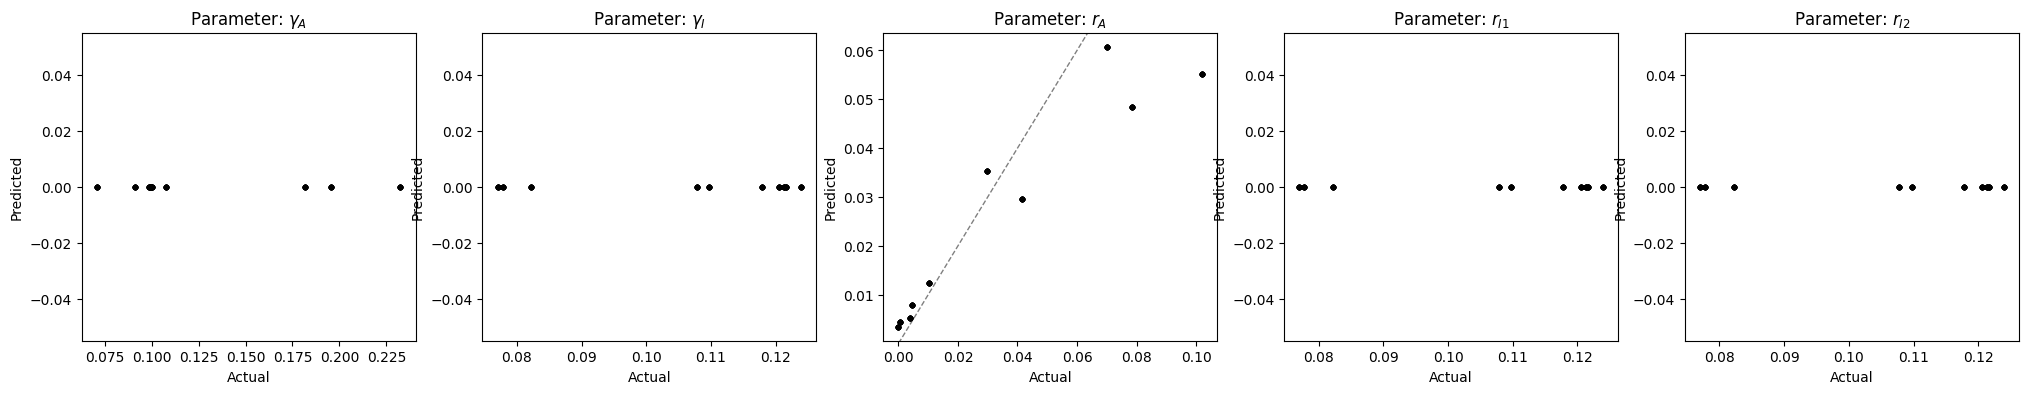

In [29]:
##############################################################################
##  Plot actual vs predicted parameter values (CHL-)

model = MODEL_CHL_NEG
nparams = NPARAMS_CHL_NEG
params_true = syn_model_params_chl_neg
params_pred = predicted_ys_chl_neg

fig, axes = plt.subplots(1, nparams, figsize=(5*nparams, 4))

for i, ax in enumerate(axes):
    param_name = model.get_inferred_param_names()[i]
    ax.plot(
        params_true[:,:,i].flatten(), params_pred[:,:,i].flatten(),
        marker=".",
        linestyle="None",
        color="k"
    )
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    xs = np.linspace(*xlims, 10)
    ax.plot(xs, xs, "--k", linewidth=1, alpha=0.5)
    ax.set_xlim(*xlims)
    ax.set_ylim(*ylims)
    ax.set_xlabel(f"Actual")
    ax.set_ylabel(f"Predicted")
    ax.set_title(f"Parameter: ${texify(param_name)}$")


Text(0.5, 1.0, 'nir mapping')

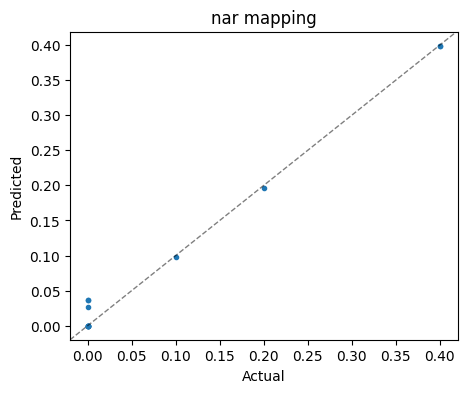

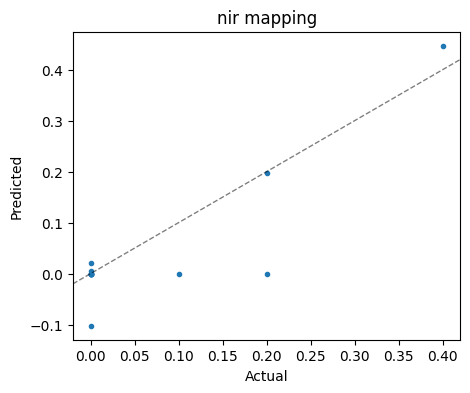

In [30]:
##############################################################################
##  Compare coefficients of transformation (CHL+)

model = MODEL_CHL_POS
nparams = NPARAMS_CHL_POS
nar_coeffs_true = T_MATRIX_NAR0_CHL_POS
nir_coeffs_true = T_MATRIX_NIR0_CHL_POS
best_coeffs = best_coeffs_chl_pos

nar_coeffs_pred = best_coeffs[:,0:7]
nir_coeffs_pred = best_coeffs[:,7:]

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(nar_coeffs_true.flatten(), nar_coeffs_pred.flatten(), '.')
xlims = ax.get_xlim()
ylims = ax.get_ylim()
xs = np.linspace(*xlims, 10)
ax.plot(xs, xs, "--k", linewidth=1, alpha=0.5)
ax.set_xlim(*xlims)
ax.set_ylim(*ylims)
ax.set_xlabel(f"Actual")
ax.set_ylabel(f"Predicted")
ax.set_title("nar mapping")

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(nir_coeffs_true.flatten(), nir_coeffs_pred.flatten(), '.')

xlims = ax.get_xlim()
ylims = ax.get_ylim()
xs = np.linspace(*xlims, 10)
ax.plot(xs, xs, "--k", linewidth=1, alpha=0.5)
ax.set_xlim(*xlims)
ax.set_ylim(*ylims)
ax.set_xlabel(f"Actual")
ax.set_ylabel(f"Predicted")
ax.set_title("nir mapping")

Text(0.5, 1.0, 'nir mapping')

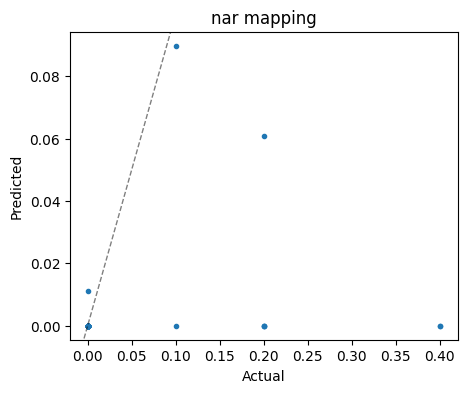

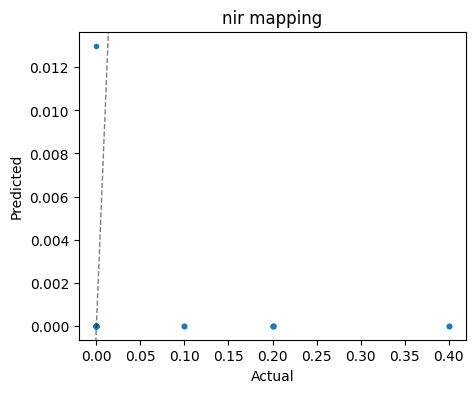

In [32]:
##############################################################################
##  Compare coefficients of transformation (CHL-)

model = MODEL_CHL_NEG
nparams = NPARAMS_CHL_NEG
nar_coeffs_true = T_MATRIX_NAR0_CHL_NEG
nir_coeffs_true = T_MATRIX_NIR0_CHL_NEG
best_coeffs = best_coeffs_chl_neg

nar_coeffs_pred = best_coeffs[:,0:7]
nir_coeffs_pred = best_coeffs[:,7:]

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(nar_coeffs_true.flatten(), nar_coeffs_pred.flatten(), '.')
xlims = ax.get_xlim()
ylims = ax.get_ylim()
xs = np.linspace(*xlims, 10)
ax.plot(xs, xs, "--k", linewidth=1, alpha=0.5)
ax.set_xlim(*xlims)
ax.set_ylim(*ylims)
ax.set_xlabel(f"Actual")
ax.set_ylabel(f"Predicted")
ax.set_title("nar mapping")

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(nir_coeffs_true.flatten(), nir_coeffs_pred.flatten(), '.')

xlims = ax.get_xlim()
ylims = ax.get_ylim()
xs = np.linspace(*xlims, 10)
ax.plot(xs, xs, "--k", linewidth=1, alpha=0.5)
ax.set_xlim(*xlims)
ax.set_ylim(*ylims)
ax.set_xlabel(f"Actual")
ax.set_ylabel(f"Predicted")
ax.set_title("nir mapping")